# INGV Volcanic : Basic_solution (STFT)
**Volcanic earthquakes** have various characteristics depending on the volcano, and there are various classifications, but the typical classifications can be classified as follows.
 
**Volcanic earthquake**
 * type A (10Hz or higher): Earthquake caused by destruction of rocks surrounding magma chambers and conduits
 * type BH (5-8Hz) : Earthquake caused by magma intruding into the conduit and destroying the conduit and rocks around the conduit
 * type BL (1.5-2.5Hz) : An earthquake around the conduit due to gas etc. ejecting from the crater prior to the explosive eruption and reducing the pressure inside the conduit.

**Volcanic tremor**
 * type C (0.5-1.2Hz) : Vibration due to increase in gas pressure in the cavity along with BH
 * type D (2-4Hz) : Vibration due to gas ejection along with BL
 
> I am a complete amateur about volcanoes. The jargon may be wrong, but please forgive me.

**Version 3**
 * At the beginning, briefly add the mechanism of earthquake and tremor
 * Corrected the unit of `time_to_eruption` from millisecond to centisecond (Thanks Alex V B)
 * Changed LightGBM parameters (Thanks [Dave E](https://www.kaggle.com/davidedwards1/volcano-stft-data-optimisation))

In [2]:
import os
import datetime
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import scipy
import scipy.signal

import matplotlib
import matplotlib.pyplot as plt
pd.options.display.max_columns = None    # disp all columns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from lightgbm import LGBMRegressor
import lightgbm as lgb

In [3]:
### Kaggle or Local-PC ###
KAGGLE = True       # <==== SET ============

if KAGGLE:
    DIR = '../input/predict-volcanic-eruptions-ingv-oe'
else:              # local PC
    DIR = './predict-volcanic-eruptions-ingv-oe/'

# Data

In [4]:
train = pd.read_csv(os.path.join(DIR, 'train.csv'))
test = pd.read_csv(os.path.join(DIR, 'sample_submission.csv'))

train

,segment_id,time_to_eruption
0,1136037770,12262005
1,1969647810,32739612
2,1895879680,14965999
3,2068207140,26469720
4,192955606,31072429
...,...,...
4426,873340274,15695097
4427,1297437712,35659379
4428,694853998,31206935
4429,1886987043,9598270


# Observe sample data

In [5]:
# plot utility function
def plot(ax, x, y, xlabel=None, ylabel=None, legend=None):
    ax.plot(x, y, label = legend)
    if xlabel != None:
        ax.set_xlabel(xlabel)
    if ylabel != None:
        ax.set_ylabel(ylabel)
    if legend != None:
        ax.legend()
    ax.grid(True)

In [5]:
segment_trial_df = pd.read_csv(os.path.join(DIR, f'train/775594946.csv'))
segment_trial_df

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
0,-804.0,428.0,-99.0,-297.0,NaN,-409.0,-331.0,1860.0,742.0,384.0
1,-820.0,439.0,-81.0,-270.0,NaN,-359.0,-290.0,1703.0,546.0,386.0
2,-779.0,442.0,-58.0,-238.0,NaN,-335.0,-268.0,1679.0,363.0,352.0
3,-766.0,287.0,-87.0,-282.0,NaN,-315.0,-281.0,1819.0,421.0,298.0
4,-745.0,-93.0,-111.0,-304.0,NaN,-321.0,-272.0,1910.0,413.0,244.0
...,...,...,...,...,...,...,...,...,...,...
59996,646.0,-1682.0,-236.0,623.0,NaN,1848.0,-127.0,458.0,19.0,1048.0
59997,799.0,-2120.0,-264.0,522.0,NaN,1535.0,-281.0,509.0,209.0,1166.0
59998,831.0,-2516.0,-295.0,502.0,NaN,1558.0,-207.0,347.0,154.0,1290.0
59999,968.0,-2675.0,-318.0,602.0,NaN,1817.0,-114.0,469.0,80.0,1336.0


In [6]:
# Select sample segment
sample_df = (train.sort_values('time_to_eruption')
             .reset_index()
             .rename(columns={'index': 'train_id'}))
sample_df = sample_df[sample_df.index % (len(train) // 5) == 5].reset_index(drop = True)
sample_ids = sample_df['segment_id'].values
sample_df

,train_id,segment_id,time_to_eruption
0,3942,775594946,52074
1,636,2078096366,8991164
2,4059,522506128,17972903
3,3851,100610446,27292311
4,2787,1003411703,36831703


### Time Domain

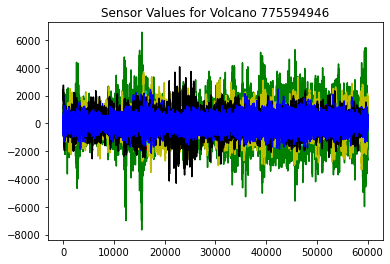

In [7]:
# sensor = 8      #### 1 ～ 10

# fig, ax = plt.subplots(len(sample_ids), 1, figsize = (12, len(sample_ids)*2))
# for i, segment_id in enumerate(sample_ids):
#     segment_df = pd.read_csv(os.path.join(DIR, f'train/{segment_id}.csv')).fillna(0)
#     ax[i].plot(range(len(segment_df)), segment_df[f'sensor_{sensor}'])
#     ax[i].set_title(f'segment_id : {segment_id},  sensor : {sensor}')

# fig.tight_layout()

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'b', 'k', 'b']

segment_id = 775594946
for i in range(1, 10):
    sensor = i
    segment_df = pd.read_csv(os.path.join(DIR, f'train/{segment_id}.csv')).fillna(0)
    plt.plot(range(len(segment_df)), segment_df[f'sensor_{sensor}'], color=colors[i-1])
plt.title('Sensor Values for Volcano 775594946')
plt.rcParams["figure.figsize"] = (20,3)

### Time-Frequency Domain (STFT)
STFT : Short Time Fourier Transform

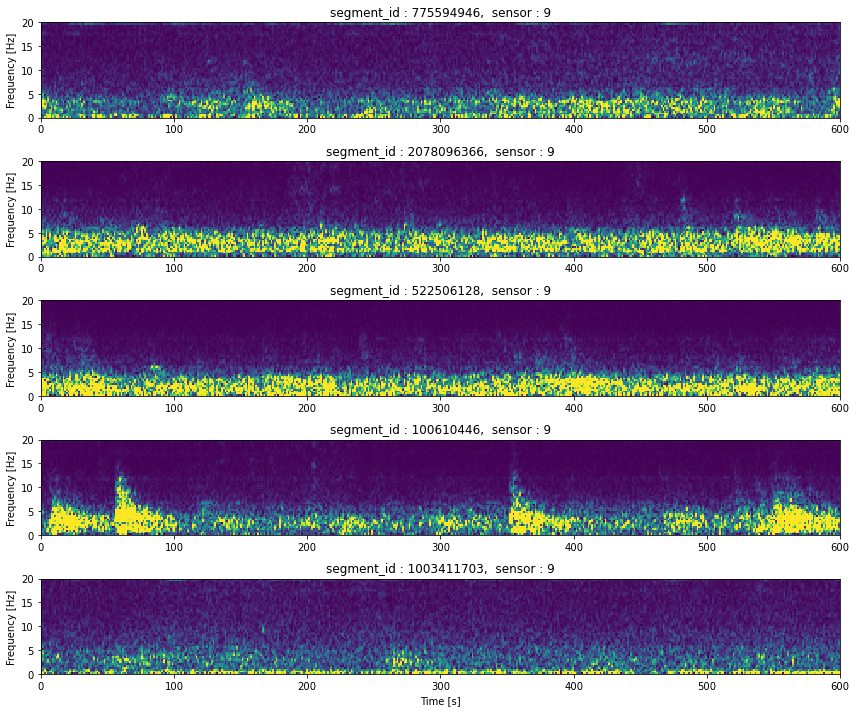

In [8]:
fs = 100                # sampling frequency 
N = len(segment_df)     # data size
n = 256                 # FFT segment size

fig, ax = plt.subplots(len(sample_ids), 1, figsize = (12, len(sample_ids)*2))
for i, segment_id in enumerate(sample_ids):
    segment_df = pd.read_csv(os.path.join(DIR, f'train/{segment_id}.csv')).fillna(0)
    
    x = segment_df[f'sensor_{sensor}'][:N]
    f, t, Z = scipy.signal.stft(x, fs = fs, window = 'hann', nperseg = n)
    Z = np.abs(Z)

    ax[i].pcolormesh(t, f, Z, vmin = 0, vmax = Z.mean()*10)
    ax[i].set_ylim(0, 20)
    ax[i].set_ylabel('Frequency [Hz]'); plt.xlabel('Time [s]')
    ax[i].set_title(f'segment_id : {segment_id},  sensor : {sensor}')
fig.tight_layout()

# Features

In [9]:
# STFT(Short Time Fourier Transform) Specifications
fs = 100                # sampling frequency 
N = len(segment_df)     # data size
n = 256                 # FFT segment size
max_f = 20              # ～20Hz

delta_f = fs / n        # 0.39Hz
delta_t = n / fs / 2    # 1.28s

In [10]:
def make_features(tgt):
    tgt_df = train if tgt == 'train' else test
    feature_set = []
    for segment_id in tqdm(tgt_df['segment_id']):
        segment_df = pd.read_csv(os.path.join(DIR,f'{tgt}/{segment_id}.csv'))
        segment = [segment_id]
        for sensor in segment_df.columns:
            x = segment_df[sensor][:N]
            if x.isna().sum() > 1000:     ##########
                segment += ([np.NaN] * 10)
                continue
            f, t, Z = scipy.signal.stft(x.fillna(0), fs = fs, window = 'hann', nperseg = n)
            f = f[:round(max_f/delta_f)+1]
            Z = np.abs(Z[:round(max_f/delta_f)+1]).T    # ～max_f, row:time,col:freq

            th = Z.mean() * 1     ##########
            Z_pow = Z.copy()
            Z_pow[Z < th] = 0
            Z_num = Z_pow.copy()
            Z_num[Z >= th] = 1

            Z_pow_sum = Z_pow.sum(axis = 0)
            Z_num_sum = Z_num.sum(axis = 0)

            A_pow = Z_pow_sum[round(10/delta_f):].sum()
            A_num = Z_num_sum[round(10/delta_f):].sum()
            BH_pow = Z_pow_sum[round(5/delta_f):round(8/delta_f)].sum()
            BH_num = Z_num_sum[round(5/delta_f):round(8/delta_f)].sum()
            BL_pow = Z_pow_sum[round(1.5/delta_f):round(2.5/delta_f)].sum()
            BL_num = Z_num_sum[round(1.5/delta_f):round(2.5/delta_f)].sum()
            C_pow = Z_pow_sum[round(0.6/delta_f):round(1.2/delta_f)].sum()
            C_num = Z_num_sum[round(0.6/delta_f):round(1.2/delta_f)].sum()
            D_pow = Z_pow_sum[round(2/delta_f):round(4/delta_f)].sum()
            D_num = Z_num_sum[round(2/delta_f):round(4/delta_f)].sum()
            segment += [A_pow, A_num, BH_pow, BH_num, BL_pow, BL_num, C_pow, C_num, D_pow, D_num]

        feature_set.append(segment)

    cols = ['segment_id']
    for i in range(10):
        for j in ['A_pow', 'A_num','BH_pow', 'BH_num','BL_pow', 'BL_num','C_pow', 'C_num','D_pow', 'D_num']:
            cols += [f's{i+1}_{j}']
    feature_df = pd.DataFrame(feature_set, columns = cols)
    feature_df['segment_id'] = feature_df['segment_id'].astype('int')
    return feature_df

In [11]:
feature_df = make_features('train')
train_set = pd.merge(train, feature_df, on = 'segment_id')
train_set

,segment_id,time_to_eruption,s1_A_pow,s1_A_num,s1_BH_pow,s1_BH_num,s1_BL_pow,s1_BL_num,s1_C_pow,s1_C_num,s1_D_pow,s1_D_num,s2_A_pow,s2_A_num,s2_BH_pow,s2_BH_num,s2_BL_pow,s2_BL_num,s2_C_pow,s2_C_num,s2_D_pow,s2_D_num,s3_A_pow,s3_A_num,s3_BH_pow,s3_BH_num,s3_BL_pow,s3_BL_num,s3_C_pow,s3_C_num,s3_D_pow,s3_D_num,s4_A_pow,s4_A_num,s4_BH_pow,s4_BH_num,s4_BL_pow,s4_BL_num,s4_C_pow,s4_C_num,s4_D_pow,s4_D_num,s5_A_pow,s5_A_num,s5_BH_pow,s5_BH_num,s5_BL_pow,s5_BL_num,s5_C_pow,s5_C_num,s5_D_pow,s5_D_num,s6_A_pow,s6_A_num,s6_BH_pow,s6_BH_num,s6_BL_pow,s6_BL_num,s6_C_pow,s6_C_num,s6_D_pow,s6_D_num,s7_A_pow,s7_A_num,s7_BH_pow,s7_BH_num,s7_BL_pow,s7_BL_num,s7_C_pow,s7_C_num,s7_D_pow,s7_D_num,s8_A_pow,s8_A_num,s8_BH_pow,s8_BH_num,s8_BL_pow,s8_BL_num,s8_C_pow,s8_C_num,s8_D_pow,s8_D_num,s9_A_pow,s9_A_num,s9_BH_pow,s9_BH_num,s9_BL_pow,s9_BL_num,s9_C_pow,s9_C_num,s9_D_pow,s9_D_num,s10_A_pow,s10_A_num,s10_BH_pow,s10_BH_num,s10_BL_pow,s10_BL_num,s10_C_pow,s10_C_num,s10_D_pow,s10_D_num
0,1136037770,12262005,0.000000,0.0,5630.045792,271.0,46725.413729,841.0,37140.925547,452.0,72426.032531,1848.0,30798.673301,421.0,331692.549021,2631.0,45379.763380,468.0,22777.932701,225.0,206242.474535,1657.0,16604.279572,522.0,47417.802709,1311.0,40676.075383,769.0,33720.229669,437.0,80642.155584,1777.0,8226.754250,220.0,182647.140506,2530.0,35439.620873,582.0,24749.721001,356.0,103910.182217,1651.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9850.349498,214.0,16342.737759,354.0,36798.893833,596.0,77124.060729,455.0,66246.422330,1193.0,64934.954957,1035.0,102382.207522,1654.0,9591.874414,200.0,54211.464091,436.0,54659.345814,936.0,55699.430380,871.0,171324.956616,2096.0,7302.118775,131.0,52497.482994,420.0,56240.599886,850.0,40650.624075,635.0,83811.917208,1731.0,48613.305829,738.0,27587.750677,383.0,136269.764337,1950.0,2120.558313,43.0,81355.190778,1444.0,84886.270473,807.0,60996.871589,442.0,157529.563619,1825.0
1,1969647810,32739612,0.000000,0.0,8239.546856,261.0,96756.954746,905.0,66797.019816,459.0,155685.002604,2091.0,28311.404222,394.0,236875.196678,2186.0,73926.011019,686.0,62508.203810,410.0,236954.067044,1889.0,0.000000,0.0,21212.917778,680.0,71868.730548,890.0,53765.696758,456.0,138627.821898,2102.0,0.000000,0.0,69588.814054,1538.0,71812.521656,866.0,49043.632001,446.0,135523.407364,2033.0,15991.156821,519.0,97574.156730,2131.0,37620.555312,702.0,14755.819719,322.0,109499.370581,1891.0,11990.687424,499.0,3199.959299,134.0,28420.061216,690.0,49615.324005,457.0,18742.696073,654.0,10419.983969,251.0,331.805383,9.0,35505.323034,723.0,90047.526424,462.0,25576.660444,762.0,11512.524601,362.0,44068.650240,1417.0,26835.691567,633.0,37839.530270,446.0,32531.761508,1003.0,2921.678551,82.0,34504.990966,875.0,78329.871087,885.0,56109.209126,442.0,178402.868514,2131.0,0.000000,0.0,110965.707014,1173.0,201698.828245,894.0,106227.822676,446.0,408403.903691,2161.0
2,1895879680,14965999,71.725726,5.0,8870.920230,441.0,49992.753708,895.0,33186.925457,451.0,79895.069257,1970.0,60841.404374,633.0,364248.554263,2555.0,48917.435679,417.0,17331.808264,163.0,264416.621659,1615.0,40.801135,3.0,18357.666521,916.0,39535.554602,864.0,30892.125860,452.0,69875.881502,1945.0,53035.528321,1636.0,79119.336288,1828.0,37269.130466,675.0,21254.507784,369.0,83760.330157,1600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,303.729067,13.0,1761.903231,69.0,34219.615180,732.0,78003.145316,463.0,22854.616940,723.0,0.000000,0.0,0.000000,0.0,17554.797533,656.0,53755.315654,463.0,15528.197577,759.0,2879.716593,120.0,12360.330994,560.0,13872.447596,475.0,45023.482933,458.0,17169.831636,694.0,7285.495271,214.0,40437.633546,1385.0,48696.184572,824.0,25843.988671,429.0,121920.149324,2090.0,37.333602,1.0,103640.522881,1860.0,103565.336246,878.0,49367.071923,433.0,194035.625316,2035.0
3,2068207140,26469720,29.114857,2.0,6797.868928,388.0,54570.017925,893.0,31405.338852,460.0,80809.405321,2029.0,23147.282953,451.0,170795.282391,2336.0,47166.139209,666.0,35778.770705,395.0,128353.964948,1751.0,0.000000,0.0,13045.1

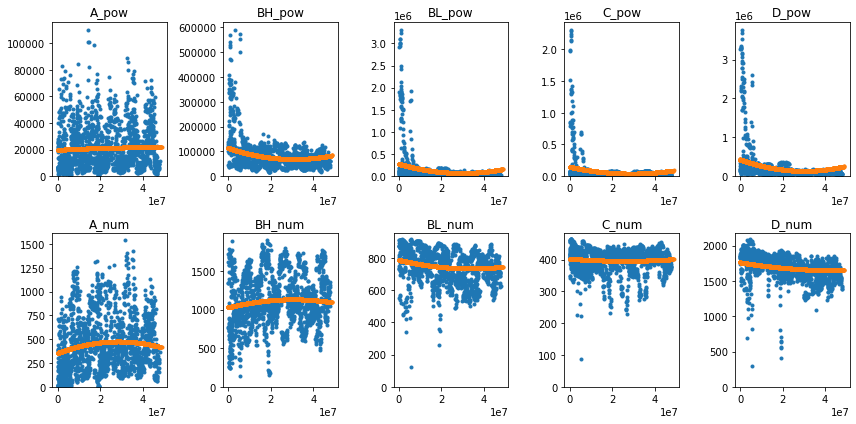

In [13]:
fig, ax = plt.subplots(2, 5, figsize = (12, 6))
x = train_set['time_to_eruption']
for i,type in enumerate(['A_pow','A_num','BH_pow','BH_num','BL_pow','BL_num','C_pow','C_num','D_pow','D_num']):
    y = np.zeros(len(x))
    for j in range(10):
        y += train_set[f's{j+1}_{type}']
    y /= 10
    x1 = np.polyfit(x, y.fillna(y.mean()), 2)
    y1 = np.poly1d(x1)(x)
    ax[i%2, i//2].plot(x, y,'.')
    ax[i%2, i//2].plot(x, y1,'.')
    ax[i%2, i//2].set_ylim(0,)
    ax[i%2, i//2].set_title(type)
fig.tight_layout()

# Modeling and Predicting

In [14]:
df = train_set.drop(['segment_id', 'time_to_eruption'], axis=1)
y = train_set['time_to_eruption']

X_train, X_val, y_train, y_val = train_test_split(df, y,
                                                  random_state = 42,
                                                  test_size = 0.2,
                                                  shuffle = True)

features = X_train.columns.tolist()
cat_features = {}

In [14]:
X_train

,s1_A_pow,s1_A_num,s1_BH_pow,s1_BH_num,s1_BL_pow,s1_BL_num,s1_C_pow,s1_C_num,s1_D_pow,s1_D_num,s2_A_pow,s2_A_num,s2_BH_pow,s2_BH_num,s2_BL_pow,s2_BL_num,s2_C_pow,s2_C_num,s2_D_pow,s2_D_num,s3_A_pow,s3_A_num,s3_BH_pow,s3_BH_num,s3_BL_pow,s3_BL_num,s3_C_pow,s3_C_num,s3_D_pow,s3_D_num,s4_A_pow,s4_A_num,s4_BH_pow,s4_BH_num,s4_BL_pow,s4_BL_num,s4_C_pow,s4_C_num,s4_D_pow,s4_D_num,s5_A_pow,s5_A_num,s5_BH_pow,s5_BH_num,s5_BL_pow,s5_BL_num,s5_C_pow,s5_C_num,s5_D_pow,s5_D_num,s6_A_pow,s6_A_num,s6_BH_pow,s6_BH_num,s6_BL_pow,s6_BL_num,s6_C_pow,s6_C_num,s6_D_pow,s6_D_num,s7_A_pow,s7_A_num,s7_BH_pow,s7_BH_num,s7_BL_pow,s7_BL_num,s7_C_pow,s7_C_num,s7_D_pow,s7_D_num,s8_A_pow,s8_A_num,s8_BH_pow,s8_BH_num,s8_BL_pow,s8_BL_num,s8_C_pow,s8_C_num,s8_D_pow,s8_D_num,s9_A_pow,s9_A_num,s9_BH_pow,s9_BH_num,s9_BL_pow,s9_BL_num,s9_C_pow,s9_C_num,s9_D_pow,s9_D_num,s10_A_pow,s10_A_num,s10_BH_pow,s10_BH_num,s10_BL_pow,s10_BL_num,s10_C_pow,s10_C_num,s10_D_pow,s10_D_num
1345,24.733614,2.0,10280.390569,606.0,3.848982e+04,879.0,2.078837e+04,441.0,7.558168e+04,2098.0,30323.058847,660.0,1.867219e+05,2590.0,2.337952e+04,456.0,1.438509e+04,273.0,1.043223e+05,1605.0,30.466014,3.0,16101.778931,963.0,2.804114e+04,848.0,1.617609e+04,446.0,6.236064e+04,2068.0,31311.123832,1271.0,5.884073e+04,1855.0,2.525071e+04,663.0,1.407469e+04,360.0,5.882038e+04,1612.0,16473.609452,892.0,72397.388242,2410.0,11545.369305,500.0,2802.941225,142.0,55581.670573,1735.0,3866.212011,244.0,395.891157,32.0,11969.078897,610.0,22292.524408,451.0,12325.317460,799.0,866.810603,76.0,1170.458349,102.0,12324.228182,673.0,34618.770145,465.0,12569.912207,877.0,14604.927261,932.0,28009.217239,1493.0,8838.324451,442.0,16333.915479,421.0,11076.847386,669.0,63211.450989,1016.0,41995.050355,1410.0,2.978563e+04,708.0,1.398417e+04,357.0,8.267834e+04,1868.0,68.604461,2.0,9.740851e+04,1718.0,7.487178e+04,824.0,3.796494e+04,420.0,1.991888e+05,2098.0
3130,264.467997,8.0,5542.664029,170.0,1.270223e+05,910.0,5.003633e+04,441.0,2.428132e+05,2204.0,47419.920197,308.0,5.924479e+05,2361.0,2.943049e+05,808.0,3.407888e+04,176.0,7.958681e+05,2075.0,710.695294,20.0,16802.371919,460.0,1.266253e+05,913.0,4.680369e+04,447.0,2.415867e+05,2197.0,135.492780,2.0,1.396111e+05,1785.0,1.526518e+05,890.0,4.313253e+04,402.0,2.915862e+05,2121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41851.606029,904.0,41585.042333,787.0,55145.237981,745.0,67531.358887,445.0,74393.968308,1294.0,31220.748108,568.0,69410.483119,1371.0,45414.639100,707.0,72299.318488,447.0,85797.995830,1535.0,18676.918441,363.0,169356.289353,2331.0,45732.932398,660.0,54032.766287,439.0,81877.170311,1309.0,2378.729683,46.0,56985.133486,1001.0,1.426556e+05,889.0,4.764652e+04,417.0,3.339426e+05,2189.0,0.000000,0.0,1.006117e+05,1172.0,2.467787e+05,902.0,7.592689e+04,428.0,5.125349e+05,2213.0
4062,3002.036584,93.0,8968.982542,295.0,7.574902e+04,874.0,4.321269e+04,446.0,1.389019e+05,2042.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,181.285800,6.0,16869.371926,556.0,6.816408e+04,866.0,3.973110e+04,449.0,1.342191e+05,2085.0,2063.492257,44.0,1.157656e+05,1637.0,5.584142e+04,693.0,2.784308e+04,339.0,1.398859e+05,1722.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,285792.883741,2236.0,21395.775464,277.0,16650.402839,207.0,92426.569834,438.0,8373.682252,114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53410.226565,700.0,125834.560222,1641.0,10331.934307,176.0,69422.134006,440.0,43718.200824,678.0,200060.075610,2225.0,65994.044360,954.0,7.381951e+04,775.0,2.843435e+04,359.0,1.788962e+05,1920.0,0.000000,0.0,9.669129e+04,1141.0,1.276370e+05,844.0,7.032974e+04,432.0,3.152859e+05,2086.0
52,555419.039597,340.0,651681.827346,364.0,4.999295e+06,898.0,3.443300e+06,461.0,4.960809e+06,1805.0,129376.967321,83.0,2.545538e+06,1429.0,3.957499e+06,889.0,2.689902e+06,454.0,6.616425e+06,2028.0,243346.193111,181.0,681968.837513,450.0,4.650563e+06,916.0,2.495337e+06,464.0,5.175790e+06,1953.0,125865.398302,97.0,1.351036e+06,934.0,4.491710e+06,913.0,2.539254e+06,464.0,5.104669e+06,1980.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [15]:
X_train.shape

(3544, 100)

In [ ]:
from sklearn import  linear_model
# from sklearn.impute import SimpleImputer

# imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
# y_imputed = imputer.fit_transform(y_train.values.reshape(-1, 1))

regr = linear_model.LinearRegression()
regr.fit(np.array(X_train.fillna(0)), y_train)

In [ ]:
print(regr.score(X_val.fillna(0), y_val))

In [ ]:
X_train

In [16]:
from keras import models
from keras import layers
from keras import optimizers
# Set up the network
network = models.Sequential()
network.add(layers.Dense(128, activation='relu', input_shape=(100,)))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(512, activation='relu'))
# network.add(layers.Dropout(0.4))
# network.add(layers.Dense(128, activation='relu'))
network.add(layers.Dropout(0.4))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dense(1))
#
# Configure the network with optimizer, loss function and accuracy
#
network.compile(optimizer=optimizers.RMSprop(lr=0.0001), 
                loss='mse', 
                metrics=['mae'])
#
# Fit the network
#
#epochs = [ 600, 700, 800, 900]
#for x in epochs:
network.compile(optimizer=optimizers.RMSprop(lr=0.0001), 
                loss='mse', 
                metrics=['mae'])
history = network.fit(X_train.fillna(0), y_train,
                    validation_data=(X_val.fillna(0), y_val),
                    epochs=500,
                    batch_size=32)

Epoch 1/600
111/111 [==============================] - 0s 4ms/step - loss: 665187086499840.0000 - mae: 22124130.0000 - val_loss: 657918122786816.0000 - val_mae: 21882746.0000
Epoch 2/600
111/111 [==============================] - 0s 2ms/step - loss: 617935869575168.0000 - mae: 21033118.0000 - val_loss: 622821663309824.0000 - val_mae: 20813858.0000
Epoch 3/600
111/111 [==============================] - 0s 2ms/step - loss: 582523931328512.0000 - mae: 19992550.0000 - val_loss: 585908432666624.0000 - val_mae: 19781246.0000
Epoch 4/600
111/111 [==============================] - 0s 2ms/step - loss: 539529127657472.0000 - mae: 19017942.0000 - val_loss: 539869436706816.0000 - val_mae: 18525958.0000
Epoch 5/600
111/111 [==============================] - 0s 2ms/step - loss: 491286410821632.0000 - mae: 17744678.0000 - val_loss: 480679989084160.0000 - val_mae: 17267810.0000
Epoch 6/600
111/111 [==============================] - 0s 2ms/step - loss: 427828034142208.0000 - mae: 16387690.0000 - val_lo

Epoch 48/600
111/111 [==============================] - 0s 3ms/step - loss: 158627184771072.0000 - mae: 9443856.0000 - val_loss: 139845343117312.0000 - val_mae: 9287919.0000
Epoch 49/600
111/111 [==============================] - 0s 2ms/step - loss: 156765266116608.0000 - mae: 9433066.0000 - val_loss: 139468241633280.0000 - val_mae: 9268127.0000
Epoch 50/600
111/111 [==============================] - 0s 3ms/step - loss: 149192718680064.0000 - mae: 9307546.0000 - val_loss: 138332474441728.0000 - val_mae: 9211262.0000
Epoch 51/600
111/111 [==============================] - 0s 2ms/step - loss: 148863163826176.0000 - mae: 9338606.0000 - val_loss: 136708121165824.0000 - val_mae: 9159731.0000
Epoch 52/600
111/111 [==============================] - 0s 2ms/step - loss: 143517607264256.0000 - mae: 9196081.0000 - val_loss: 134506438721536.0000 - val_mae: 9067446.0000
Epoch 53/600
111/111 [==============================] - 0s 2ms/step - loss: 145661550919680.0000 - mae: 9208369.0000 - val_loss: 1

111/111 [==============================] - 0s 3ms/step - loss: 101542245957632.0000 - mae: 7785752.5000 - val_loss: 93641494233088.0000 - val_mae: 7487029.5000
Epoch 96/600
111/111 [==============================] - 0s 3ms/step - loss: 101524772487168.0000 - mae: 7772753.0000 - val_loss: 94364466413568.0000 - val_mae: 7512402.5000
Epoch 97/600
111/111 [==============================] - 0s 2ms/step - loss: 101334636298240.0000 - mae: 7752924.5000 - val_loss: 92443206746112.0000 - val_mae: 7427364.5000
Epoch 98/600
111/111 [==============================] - 0s 2ms/step - loss: 100153906167808.0000 - mae: 7695882.5000 - val_loss: 91268491247616.0000 - val_mae: 7385113.0000
Epoch 99/600
111/111 [==============================] - 0s 2ms/step - loss: 97783855972352.0000 - mae: 7639630.0000 - val_loss: 92289040908288.0000 - val_mae: 7430778.5000
Epoch 100/600
111/111 [==============================] - 0s 2ms/step - loss: 98287046623232.0000 - mae: 7665659.5000 - val_loss: 90613106081792.0000 

111/111 [==============================] - 0s 3ms/step - loss: 80292903649280.0000 - mae: 6907298.5000 - val_loss: 72868473864192.0000 - val_mae: 6583580.0000
Epoch 143/600
111/111 [==============================] - 0s 2ms/step - loss: 81039221325824.0000 - mae: 6922878.0000 - val_loss: 72944843751424.0000 - val_mae: 6574698.0000
Epoch 144/600
111/111 [==============================] - 0s 2ms/step - loss: 80839203356672.0000 - mae: 6928611.5000 - val_loss: 72616907898880.0000 - val_mae: 6562184.5000
Epoch 145/600
111/111 [==============================] - 0s 2ms/step - loss: 82000153149440.0000 - mae: 6938104.5000 - val_loss: 72168536801280.0000 - val_mae: 6535262.0000
Epoch 146/600
111/111 [==============================] - 0s 3ms/step - loss: 80986876411904.0000 - mae: 6943667.5000 - val_loss: 71307471355904.0000 - val_mae: 6509773.5000
Epoch 147/600
111/111 [==============================] - 0s 3ms/step - loss: 81939033751552.0000 - mae: 6984323.0000 - val_loss: 71517094281216.0000 

111/111 [==============================] - 0s 2ms/step - loss: 71590301663232.0000 - mae: 6506404.0000 - val_loss: 62153163800576.0000 - val_mae: 6002652.0000
Epoch 190/600
111/111 [==============================] - 0s 2ms/step - loss: 72351483953152.0000 - mae: 6543660.0000 - val_loss: 61422667038720.0000 - val_mae: 5990445.0000
Epoch 191/600
111/111 [==============================] - 0s 2ms/step - loss: 73515789189120.0000 - mae: 6603965.5000 - val_loss: 62906565656576.0000 - val_mae: 6018351.0000
Epoch 192/600
111/111 [==============================] - 0s 2ms/step - loss: 72362967957504.0000 - mae: 6518196.5000 - val_loss: 63175235993600.0000 - val_mae: 6025792.5000
Epoch 193/600
111/111 [==============================] - 0s 2ms/step - loss: 70610654855168.0000 - mae: 6472009.0000 - val_loss: 61202365415424.0000 - val_mae: 5967759.0000
Epoch 194/600
111/111 [==============================] - 0s 2ms/step - loss: 71811274375168.0000 - mae: 6499841.0000 - val_loss: 61101739868160.0000 

111/111 [==============================] - 0s 3ms/step - loss: 66170451394560.0000 - mae: 6245271.5000 - val_loss: 55250585124864.0000 - val_mae: 5670318.0000
Epoch 237/600
111/111 [==============================] - 0s 2ms/step - loss: 66018256879616.0000 - mae: 6193359.0000 - val_loss: 55514830471168.0000 - val_mae: 5664759.0000
Epoch 238/600
111/111 [==============================] - 0s 3ms/step - loss: 64938764664832.0000 - mae: 6140750.5000 - val_loss: 55094657679360.0000 - val_mae: 5636663.0000
Epoch 239/600
111/111 [==============================] - 0s 2ms/step - loss: 65974803890176.0000 - mae: 6196735.0000 - val_loss: 55605804924928.0000 - val_mae: 5657547.0000
Epoch 240/600
111/111 [==============================] - 0s 2ms/step - loss: 64580411719680.0000 - mae: 6158353.0000 - val_loss: 55303194279936.0000 - val_mae: 5644857.0000
Epoch 241/600
111/111 [==============================] - 0s 2ms/step - loss: 63115475550208.0000 - mae: 6124944.5000 - val_loss: 54915195994112.0000 

111/111 [==============================] - 0s 2ms/step - loss: 61214759583744.0000 - mae: 5997760.5000 - val_loss: 51432451473408.0000 - val_mae: 5415890.0000
Epoch 284/600
111/111 [==============================] - 0s 2ms/step - loss: 62541019480064.0000 - mae: 6026417.0000 - val_loss: 51805811638272.0000 - val_mae: 5425066.5000
Epoch 285/600
111/111 [==============================] - 0s 2ms/step - loss: 61007439331328.0000 - mae: 5964425.5000 - val_loss: 51051176656896.0000 - val_mae: 5395921.0000
Epoch 286/600
111/111 [==============================] - 0s 2ms/step - loss: 60709941542912.0000 - mae: 5901947.5000 - val_loss: 51194340835328.0000 - val_mae: 5404265.0000
Epoch 287/600
111/111 [==============================] - 0s 2ms/step - loss: 62184214233088.0000 - mae: 6039417.0000 - val_loss: 51374167425024.0000 - val_mae: 5409098.0000
Epoch 288/600
111/111 [==============================] - 0s 2ms/step - loss: 60641683439616.0000 - mae: 5960421.0000 - val_loss: 50412438683648.0000 

111/111 [==============================] - 0s 2ms/step - loss: 61421580713984.0000 - mae: 5955941.0000 - val_loss: 48220906455040.0000 - val_mae: 5227605.5000
Epoch 331/600
111/111 [==============================] - 0s 2ms/step - loss: 57269865676800.0000 - mae: 5810835.5000 - val_loss: 49041014521856.0000 - val_mae: 5253434.0000
Epoch 332/600
111/111 [==============================] - 0s 2ms/step - loss: 58299462451200.0000 - mae: 5866803.5000 - val_loss: 47342321401856.0000 - val_mae: 5185830.5000
Epoch 333/600
111/111 [==============================] - 0s 2ms/step - loss: 62986563616768.0000 - mae: 5855435.0000 - val_loss: 48054073819136.0000 - val_mae: 5208510.0000
Epoch 334/600
111/111 [==============================] - 0s 2ms/step - loss: 57625769148416.0000 - mae: 5760150.0000 - val_loss: 48150035300352.0000 - val_mae: 5215808.5000
Epoch 335/600
111/111 [==============================] - 0s 2ms/step - loss: 59956258668544.0000 - mae: 5863370.5000 - val_loss: 47539810205696.0000 

111/111 [==============================] - 0s 3ms/step - loss: 55782796165120.0000 - mae: 5671495.0000 - val_loss: 44659527122944.0000 - val_mae: 4979940.0000
Epoch 378/600
111/111 [==============================] - 0s 3ms/step - loss: 56922682163200.0000 - mae: 5766170.5000 - val_loss: 45387213701120.0000 - val_mae: 5031412.5000
Epoch 379/600
111/111 [==============================] - 0s 3ms/step - loss: 54441751347200.0000 - mae: 5648279.0000 - val_loss: 45533712351232.0000 - val_mae: 5028561.5000
Epoch 380/600
111/111 [==============================] - 0s 3ms/step - loss: 54910234132480.0000 - mae: 5665741.0000 - val_loss: 44742620479488.0000 - val_mae: 4992515.0000
Epoch 381/600
111/111 [==============================] - 0s 3ms/step - loss: 57706182344704.0000 - mae: 5678699.5000 - val_loss: 45994167238656.0000 - val_mae: 5063606.5000
Epoch 382/600
111/111 [==============================] - 0s 3ms/step - loss: 56699167703040.0000 - mae: 5793024.0000 - val_loss: 45826466381824.0000 

111/111 [==============================] - 0s 3ms/step - loss: 54670080868352.0000 - mae: 5540589.0000 - val_loss: 42339858907136.0000 - val_mae: 4826299.0000
Epoch 425/600
111/111 [==============================] - 0s 3ms/step - loss: 53085397319680.0000 - mae: 5538101.0000 - val_loss: 42486659547136.0000 - val_mae: 4828102.5000
Epoch 426/600
111/111 [==============================] - 0s 3ms/step - loss: 53408979484672.0000 - mae: 5562772.0000 - val_loss: 42551218274304.0000 - val_mae: 4843899.0000
Epoch 427/600
111/111 [==============================] - 0s 3ms/step - loss: 51638060449792.0000 - mae: 5440266.0000 - val_loss: 42736367435776.0000 - val_mae: 4864386.5000
Epoch 428/600
111/111 [==============================] - 0s 3ms/step - loss: 53996043632640.0000 - mae: 5558666.0000 - val_loss: 42854852329472.0000 - val_mae: 4849985.5000
Epoch 429/600
111/111 [==============================] - 0s 3ms/step - loss: 54125060423680.0000 - mae: 5560807.0000 - val_loss: 42043313225728.0000 

111/111 [==============================] - 0s 2ms/step - loss: 50291797917696.0000 - mae: 5395359.5000 - val_loss: 41081337020416.0000 - val_mae: 4746521.5000
Epoch 472/600
111/111 [==============================] - 0s 3ms/step - loss: 54712770494464.0000 - mae: 5539303.0000 - val_loss: 40699374338048.0000 - val_mae: 4720948.5000
Epoch 473/600
111/111 [==============================] - 0s 2ms/step - loss: 51394534965248.0000 - mae: 5450982.0000 - val_loss: 41177860538368.0000 - val_mae: 4746243.0000
Epoch 474/600
111/111 [==============================] - 0s 2ms/step - loss: 51030507126784.0000 - mae: 5400277.0000 - val_loss: 40501097005056.0000 - val_mae: 4701359.5000
Epoch 475/600
111/111 [==============================] - 0s 2ms/step - loss: 50125011419136.0000 - mae: 5421079.5000 - val_loss: 40205067223040.0000 - val_mae: 4685710.5000
Epoch 476/600
111/111 [==============================] - 0s 2ms/step - loss: 53569545830400.0000 - mae: 5439310.5000 - val_loss: 40844220432384.0000 

111/111 [==============================] - 0s 2ms/step - loss: 48306239569920.0000 - mae: 5283302.5000 - val_loss: 39170290483200.0000 - val_mae: 4596286.0000
Epoch 519/600
111/111 [==============================] - 0s 2ms/step - loss: 49558067347456.0000 - mae: 5290401.0000 - val_loss: 38695793065984.0000 - val_mae: 4579585.0000
Epoch 520/600
111/111 [==============================] - 0s 2ms/step - loss: 48918473736192.0000 - mae: 5243351.5000 - val_loss: 38380679200768.0000 - val_mae: 4541336.5000
Epoch 521/600
111/111 [==============================] - 0s 2ms/step - loss: 49629102080000.0000 - mae: 5307893.5000 - val_loss: 38637060227072.0000 - val_mae: 4592794.5000
Epoch 522/600
111/111 [==============================] - 0s 2ms/step - loss: 50290673844224.0000 - mae: 5335922.0000 - val_loss: 39215383445504.0000 - val_mae: 4613218.5000
Epoch 523/600
111/111 [==============================] - 0s 2ms/step - loss: 49534575050752.0000 - mae: 5300685.5000 - val_loss: 38920255438848.0000 

111/111 [==============================] - 0s 2ms/step - loss: 46972463480832.0000 - mae: 5232411.5000 - val_loss: 37666963849216.0000 - val_mae: 4504881.5000
Epoch 566/600
111/111 [==============================] - 0s 3ms/step - loss: 45689237143552.0000 - mae: 5147441.5000 - val_loss: 36931530391552.0000 - val_mae: 4454867.0000
Epoch 567/600
111/111 [==============================] - 0s 2ms/step - loss: 51545899008000.0000 - mae: 5288192.5000 - val_loss: 37229862846464.0000 - val_mae: 4503823.0000
Epoch 568/600
111/111 [==============================] - 0s 3ms/step - loss: 49124862853120.0000 - mae: 5287490.0000 - val_loss: 37308451520512.0000 - val_mae: 4506968.0000
Epoch 569/600
111/111 [==============================] - 0s 2ms/step - loss: 47758408941568.0000 - mae: 5202801.5000 - val_loss: 37392614424576.0000 - val_mae: 4492651.0000
Epoch 570/600
111/111 [==============================] - 0s 2ms/step - loss: 49583593881600.0000 - mae: 5298019.0000 - val_loss: 37786061111296.0000 

111/111 [==============================] - 0s 2ms/step - loss: 46414725906432.0000 - mae: 5178550.0000 - val_loss: 36541275570176.0000 - val_mae: 4456075.0000
Epoch 13/700
111/111 [==============================] - 0s 2ms/step - loss: 46205534994432.0000 - mae: 5158616.5000 - val_loss: 35161500549120.0000 - val_mae: 4345366.0000
Epoch 14/700
111/111 [==============================] - 0s 2ms/step - loss: 46928100327424.0000 - mae: 5149448.5000 - val_loss: 36433628758016.0000 - val_mae: 4448467.0000
Epoch 15/700
111/111 [==============================] - 0s 2ms/step - loss: 46819195224064.0000 - mae: 5156063.5000 - val_loss: 36412237807616.0000 - val_mae: 4443438.0000
Epoch 16/700
111/111 [==============================] - 0s 2ms/step - loss: 47578406191104.0000 - mae: 5220400.0000 - val_loss: 35263027871744.0000 - val_mae: 4340797.5000
Epoch 17/700
111/111 [==============================] - 0s 2ms/step - loss: 45239804887040.0000 - mae: 5063871.5000 - val_loss: 37739558862848.0000 - val

Epoch 60/700
111/111 [==============================] - 0s 3ms/step - loss: 45418029252608.0000 - mae: 5097870.0000 - val_loss: 35532746784768.0000 - val_mae: 4393928.5000
Epoch 61/700
111/111 [==============================] - 0s 3ms/step - loss: 45281693401088.0000 - mae: 5071499.5000 - val_loss: 35445287157760.0000 - val_mae: 4389098.0000
Epoch 62/700
111/111 [==============================] - 0s 3ms/step - loss: 43888282697728.0000 - mae: 5021141.0000 - val_loss: 36209199939584.0000 - val_mae: 4451025.0000
Epoch 63/700
111/111 [==============================] - 0s 3ms/step - loss: 43896050548736.0000 - mae: 5008310.5000 - val_loss: 34346339663872.0000 - val_mae: 4310891.5000
Epoch 64/700
111/111 [==============================] - 0s 3ms/step - loss: 45376983793664.0000 - mae: 5110084.0000 - val_loss: 34500060905472.0000 - val_mae: 4320029.5000
Epoch 65/700
111/111 [==============================] - 0s 3ms/step - loss: 44270480261120.0000 - mae: 5064571.5000 - val_loss: 353575716782

111/111 [==============================] - 0s 2ms/step - loss: 43169676787712.0000 - mae: 4936570.0000 - val_loss: 34259655983104.0000 - val_mae: 4296008.0000
Epoch 108/700
111/111 [==============================] - 0s 2ms/step - loss: 44015353331712.0000 - mae: 4974974.0000 - val_loss: 34927192047616.0000 - val_mae: 4365307.0000
Epoch 109/700
111/111 [==============================] - 0s 2ms/step - loss: 44894202626048.0000 - mae: 4955690.0000 - val_loss: 34083321151488.0000 - val_mae: 4310534.5000
Epoch 110/700
111/111 [==============================] - 0s 2ms/step - loss: 53421759528960.0000 - mae: 4963437.0000 - val_loss: 35805523345408.0000 - val_mae: 4438592.0000
Epoch 111/700
111/111 [==============================] - 0s 2ms/step - loss: 43316414513152.0000 - mae: 4997230.0000 - val_loss: 33214838079488.0000 - val_mae: 4229019.0000
Epoch 112/700
111/111 [==============================] - 0s 2ms/step - loss: 42622768906240.0000 - mae: 4916460.0000 - val_loss: 33739757322240.0000 

111/111 [==============================] - 0s 2ms/step - loss: 48799317753856.0000 - mae: 4899930.5000 - val_loss: 33606697222144.0000 - val_mae: 4280802.0000
Epoch 155/700
111/111 [==============================] - 0s 2ms/step - loss: 42073709346816.0000 - mae: 4889063.5000 - val_loss: 32554929356800.0000 - val_mae: 4202736.5000
Epoch 156/700
111/111 [==============================] - 0s 2ms/step - loss: 42163568115712.0000 - mae: 4935817.5000 - val_loss: 33169944346624.0000 - val_mae: 4248553.0000
Epoch 157/700
111/111 [==============================] - 0s 3ms/step - loss: 41393124802560.0000 - mae: 4829237.5000 - val_loss: 33989599428608.0000 - val_mae: 4335068.5000
Epoch 158/700
111/111 [==============================] - 0s 4ms/step - loss: 42826599497728.0000 - mae: 4897427.0000 - val_loss: 32619991400448.0000 - val_mae: 4202391.0000
Epoch 159/700
111/111 [==============================] - 0s 3ms/step - loss: 41336229068800.0000 - mae: 4841687.5000 - val_loss: 33784657346560.0000 

111/111 [==============================] - 0s 2ms/step - loss: 39821439401984.0000 - mae: 4772535.5000 - val_loss: 33089279492096.0000 - val_mae: 4246785.0000
Epoch 202/700
111/111 [==============================] - 0s 2ms/step - loss: 40131989864448.0000 - mae: 4762398.0000 - val_loss: 33057448919040.0000 - val_mae: 4293827.0000
Epoch 203/700
111/111 [==============================] - 0s 2ms/step - loss: 43482446036992.0000 - mae: 4930926.0000 - val_loss: 35118334869504.0000 - val_mae: 4392655.5000
Epoch 204/700
111/111 [==============================] - 0s 2ms/step - loss: 41521462116352.0000 - mae: 4804651.0000 - val_loss: 31907775512576.0000 - val_mae: 4176866.0000
Epoch 205/700
111/111 [==============================] - 0s 2ms/step - loss: 41204116881408.0000 - mae: 4830936.5000 - val_loss: 32626888933376.0000 - val_mae: 4251041.0000
Epoch 206/700
111/111 [==============================] - 0s 3ms/step - loss: 41328985505792.0000 - mae: 4812905.5000 - val_loss: 33838583513088.0000 

111/111 [==============================] - 0s 2ms/step - loss: 41537505329152.0000 - mae: 4861273.5000 - val_loss: 31359229755392.0000 - val_mae: 4158699.2500
Epoch 249/700
111/111 [==============================] - 0s 2ms/step - loss: 40750809088000.0000 - mae: 4759925.5000 - val_loss: 33854098243584.0000 - val_mae: 4362273.0000
Epoch 250/700
111/111 [==============================] - 0s 2ms/step - loss: 40854228041728.0000 - mae: 4806421.0000 - val_loss: 34238080483328.0000 - val_mae: 4362350.0000
Epoch 251/700
111/111 [==============================] - 0s 2ms/step - loss: 39567130361856.0000 - mae: 4687856.5000 - val_loss: 36894108811264.0000 - val_mae: 4538545.5000
Epoch 252/700
111/111 [==============================] - 0s 2ms/step - loss: 40753128538112.0000 - mae: 4804813.0000 - val_loss: 40268841615360.0000 - val_mae: 4822129.5000
Epoch 253/700
111/111 [==============================] - 0s 2ms/step - loss: 42044097560576.0000 - mae: 4820208.5000 - val_loss: 35356435021824.0000 

111/111 [==============================] - 0s 2ms/step - loss: 38955491786752.0000 - mae: 4692811.5000 - val_loss: 34960287203328.0000 - val_mae: 4432179.0000
Epoch 296/700
111/111 [==============================] - 0s 3ms/step - loss: 37736824176640.0000 - mae: 4602580.0000 - val_loss: 33457147215872.0000 - val_mae: 4328326.0000
Epoch 297/700
111/111 [==============================] - 0s 3ms/step - loss: 39962892304384.0000 - mae: 4783389.0000 - val_loss: 33268051214336.0000 - val_mae: 4326857.0000
Epoch 298/700
111/111 [==============================] - 0s 2ms/step - loss: 39092611973120.0000 - mae: 4725417.0000 - val_loss: 36538796736512.0000 - val_mae: 4558100.0000
Epoch 299/700
111/111 [==============================] - 0s 2ms/step - loss: 40165527519232.0000 - mae: 4773367.5000 - val_loss: 35701403942912.0000 - val_mae: 4498007.5000
Epoch 300/700
111/111 [==============================] - 0s 2ms/step - loss: 38730609983488.0000 - mae: 4684620.5000 - val_loss: 38450656968704.0000 

111/111 [==============================] - 0s 2ms/step - loss: 38504235008000.0000 - mae: 4641713.0000 - val_loss: 36516323655680.0000 - val_mae: 4571192.0000
Epoch 343/700
111/111 [==============================] - 0s 2ms/step - loss: 39563011555328.0000 - mae: 4666378.0000 - val_loss: 37946971389952.0000 - val_mae: 4665539.5000
Epoch 344/700
111/111 [==============================] - 0s 3ms/step - loss: 39285243772928.0000 - mae: 4591819.5000 - val_loss: 38948231446528.0000 - val_mae: 4743733.5000
Epoch 345/700
111/111 [==============================] - 0s 2ms/step - loss: 38956196429824.0000 - mae: 4633025.5000 - val_loss: 36044187631616.0000 - val_mae: 4534963.5000
Epoch 346/700
111/111 [==============================] - 0s 2ms/step - loss: 37770462494720.0000 - mae: 4649704.0000 - val_loss: 34948918542336.0000 - val_mae: 4456340.0000
Epoch 347/700
111/111 [==============================] - 0s 2ms/step - loss: 36673907851264.0000 - mae: 4539790.5000 - val_loss: 36852924940288.0000 

111/111 [==============================] - 0s 3ms/step - loss: 35840793247744.0000 - mae: 4477789.0000 - val_loss: 38190723366912.0000 - val_mae: 4744572.5000
Epoch 390/700
111/111 [==============================] - 0s 3ms/step - loss: 37015525523456.0000 - mae: 4537823.0000 - val_loss: 39047300907008.0000 - val_mae: 4770596.5000
Epoch 391/700
111/111 [==============================] - 0s 3ms/step - loss: 38533892931584.0000 - mae: 4580685.0000 - val_loss: 37876360282112.0000 - val_mae: 4694597.0000
Epoch 392/700
111/111 [==============================] - 0s 3ms/step - loss: 36509059121152.0000 - mae: 4545221.5000 - val_loss: 39078594609152.0000 - val_mae: 4762706.5000
Epoch 393/700
111/111 [==============================] - 0s 3ms/step - loss: 38432675987456.0000 - mae: 4613032.5000 - val_loss: 35410415714304.0000 - val_mae: 4506227.5000
Epoch 394/700
111/111 [==============================] - 0s 3ms/step - loss: 38740512735232.0000 - mae: 4702035.0000 - val_loss: 34991192932352.0000 

111/111 [==============================] - 0s 2ms/step - loss: 36658661556224.0000 - mae: 4552047.5000 - val_loss: 36932012736512.0000 - val_mae: 4642223.0000
Epoch 437/700
111/111 [==============================] - 0s 2ms/step - loss: 37647145762816.0000 - mae: 4482511.0000 - val_loss: 40915271942144.0000 - val_mae: 4906719.5000
Epoch 438/700
111/111 [==============================] - 0s 2ms/step - loss: 36131290742784.0000 - mae: 4487581.0000 - val_loss: 38172037742592.0000 - val_mae: 4714493.5000
Epoch 439/700
111/111 [==============================] - 0s 2ms/step - loss: 37070865170432.0000 - mae: 4567103.5000 - val_loss: 49074237603840.0000 - val_mae: 5475964.5000
Epoch 440/700
111/111 [==============================] - 0s 2ms/step - loss: 35146090676224.0000 - mae: 4468546.0000 - val_loss: 42314156212224.0000 - val_mae: 4983703.0000
Epoch 441/700
111/111 [==============================] - 0s 2ms/step - loss: 37787717861376.0000 - mae: 4557081.0000 - val_loss: 42412009324544.0000 

111/111 [==============================] - 0s 3ms/step - loss: 35547586232320.0000 - mae: 4451868.0000 - val_loss: 44657044094976.0000 - val_mae: 5193383.0000
Epoch 484/700
111/111 [==============================] - 0s 2ms/step - loss: 35135416172544.0000 - mae: 4420413.5000 - val_loss: 44393515974656.0000 - val_mae: 5175614.0000
Epoch 485/700
111/111 [==============================] - 0s 2ms/step - loss: 35127944019968.0000 - mae: 4422381.0000 - val_loss: 41809824710656.0000 - val_mae: 5003619.5000
Epoch 486/700
111/111 [==============================] - 0s 2ms/step - loss: 37257213902848.0000 - mae: 4552941.0000 - val_loss: 41880511315968.0000 - val_mae: 4999866.0000
Epoch 487/700
111/111 [==============================] - 0s 3ms/step - loss: 38006815719424.0000 - mae: 4465541.0000 - val_loss: 41513459384320.0000 - val_mae: 4984433.5000
Epoch 488/700
111/111 [==============================] - 0s 3ms/step - loss: 34032295346176.0000 - mae: 4410730.5000 - val_loss: 45034342711296.0000 

111/111 [==============================] - 0s 2ms/step - loss: 34336552255488.0000 - mae: 4375219.0000 - val_loss: 40500446887936.0000 - val_mae: 4878198.0000
Epoch 531/700
111/111 [==============================] - 0s 3ms/step - loss: 33305210650624.0000 - mae: 4396159.0000 - val_loss: 46091764498432.0000 - val_mae: 5278372.0000
Epoch 532/700
111/111 [==============================] - 0s 2ms/step - loss: 33015394729984.0000 - mae: 4283356.5000 - val_loss: 42255809249280.0000 - val_mae: 5028691.5000
Epoch 533/700
111/111 [==============================] - 0s 2ms/step - loss: 35025955323904.0000 - mae: 4384395.5000 - val_loss: 44412914630656.0000 - val_mae: 5183404.5000
Epoch 534/700
111/111 [==============================] - 0s 2ms/step - loss: 33150084317184.0000 - mae: 4332394.0000 - val_loss: 45037379387392.0000 - val_mae: 5214639.0000
Epoch 535/700
111/111 [==============================] - 0s 2ms/step - loss: 35068187770880.0000 - mae: 4425356.5000 - val_loss: 47530217832448.0000 

111/111 [==============================] - 0s 2ms/step - loss: 36544123502592.0000 - mae: 4432573.5000 - val_loss: 45268460371968.0000 - val_mae: 5251565.0000
Epoch 578/700
111/111 [==============================] - 0s 3ms/step - loss: 33360179101696.0000 - mae: 4326829.5000 - val_loss: 51588102094848.0000 - val_mae: 5695551.5000
Epoch 579/700
111/111 [==============================] - 0s 2ms/step - loss: 32455306248192.0000 - mae: 4239283.0000 - val_loss: 51811822075904.0000 - val_mae: 5719377.5000
Epoch 580/700
111/111 [==============================] - 0s 3ms/step - loss: 33059122446336.0000 - mae: 4296812.5000 - val_loss: 43557196922880.0000 - val_mae: 5133296.0000
Epoch 581/700
111/111 [==============================] - 0s 2ms/step - loss: 34231543660544.0000 - mae: 4320978.5000 - val_loss: 40075396120576.0000 - val_mae: 4875802.5000
Epoch 582/700
111/111 [==============================] - 0s 3ms/step - loss: 33810708168704.0000 - mae: 4341998.5000 - val_loss: 43584241795072.0000 

111/111 [==============================] - 0s 2ms/step - loss: 33518451163136.0000 - mae: 4298331.5000 - val_loss: 45195336876032.0000 - val_mae: 5264503.0000
Epoch 625/700
111/111 [==============================] - 0s 3ms/step - loss: 32280286330880.0000 - mae: 4245856.0000 - val_loss: 50076865003520.0000 - val_mae: 5594847.5000
Epoch 626/700
111/111 [==============================] - 0s 2ms/step - loss: 32264366850048.0000 - mae: 4278784.5000 - val_loss: 45100461719552.0000 - val_mae: 5266110.5000
Epoch 627/700
111/111 [==============================] - 0s 2ms/step - loss: 32399721234432.0000 - mae: 4289246.0000 - val_loss: 50109941284864.0000 - val_mae: 5610755.0000
Epoch 628/700
111/111 [==============================] - 0s 3ms/step - loss: 32958345904128.0000 - mae: 4255041.5000 - val_loss: 50474585686016.0000 - val_mae: 5630901.0000
Epoch 629/700
111/111 [==============================] - 0s 2ms/step - loss: 33064063336448.0000 - mae: 4235464.0000 - val_loss: 53272467472384.0000 

111/111 [==============================] - 0s 3ms/step - loss: 33187564617728.0000 - mae: 4283758.5000 - val_loss: 53313110278144.0000 - val_mae: 5826405.5000
Epoch 672/700
111/111 [==============================] - 0s 3ms/step - loss: 32155872788480.0000 - mae: 4259609.0000 - val_loss: 51739877179392.0000 - val_mae: 5717439.0000
Epoch 673/700
111/111 [==============================] - 0s 3ms/step - loss: 31656440233984.0000 - mae: 4247635.0000 - val_loss: 47896233771008.0000 - val_mae: 5474304.5000
Epoch 674/700
111/111 [==============================] - 0s 2ms/step - loss: 30845400252416.0000 - mae: 4152080.0000 - val_loss: 49296028205056.0000 - val_mae: 5583235.5000
Epoch 675/700
111/111 [==============================] - 0s 3ms/step - loss: 32932769038336.0000 - mae: 4259507.5000 - val_loss: 49110346366976.0000 - val_mae: 5559520.5000
Epoch 676/700
111/111 [==============================] - 0s 2ms/step - loss: 32180967309312.0000 - mae: 4231917.0000 - val_loss: 49045535981568.0000 

111/111 [==============================] - 0s 3ms/step - loss: 31744365428736.0000 - mae: 4196047.0000 - val_loss: 52276022476800.0000 - val_mae: 5756981.5000
Epoch 19/800
111/111 [==============================] - 0s 3ms/step - loss: 33090768470016.0000 - mae: 4278041.0000 - val_loss: 55576532877312.0000 - val_mae: 5965352.5000
Epoch 20/800
111/111 [==============================] - 0s 3ms/step - loss: 30384242819072.0000 - mae: 4076300.2500 - val_loss: 62279223607296.0000 - val_mae: 6361279.0000
Epoch 21/800
111/111 [==============================] - 0s 3ms/step - loss: 30866556321792.0000 - mae: 4176038.5000 - val_loss: 52398236106752.0000 - val_mae: 5753147.5000
Epoch 22/800
111/111 [==============================] - 0s 3ms/step - loss: 33283018588160.0000 - mae: 4263450.5000 - val_loss: 50810226475008.0000 - val_mae: 5655450.0000
Epoch 23/800
111/111 [==============================] - 0s 3ms/step - loss: 31828022919168.0000 - mae: 4241476.0000 - val_loss: 57393627004928.0000 - val

Epoch 66/800
111/111 [==============================] - 0s 3ms/step - loss: 32997101273088.0000 - mae: 4228161.0000 - val_loss: 53543167852544.0000 - val_mae: 5827878.0000
Epoch 67/800
111/111 [==============================] - 0s 3ms/step - loss: 32729913622528.0000 - mae: 4198570.5000 - val_loss: 54805187788800.0000 - val_mae: 5901861.5000
Epoch 68/800
111/111 [==============================] - 0s 3ms/step - loss: 31193277923328.0000 - mae: 4149127.5000 - val_loss: 49528774328320.0000 - val_mae: 5589225.0000
Epoch 69/800
111/111 [==============================] - 0s 3ms/step - loss: 32651587092480.0000 - mae: 4255056.5000 - val_loss: 60973863927808.0000 - val_mae: 6308152.5000
Epoch 70/800
111/111 [==============================] - 0s 3ms/step - loss: 30947793698816.0000 - mae: 4161006.7500 - val_loss: 52413201383424.0000 - val_mae: 5769582.0000
Epoch 71/800
111/111 [==============================] - 0s 3ms/step - loss: 31281136009216.0000 - mae: 4153071.2500 - val_loss: 509361982013

111/111 [==============================] - 0s 3ms/step - loss: 30193091608576.0000 - mae: 4114921.7500 - val_loss: 60269136969728.0000 - val_mae: 6245129.0000
Epoch 114/800
111/111 [==============================] - 0s 2ms/step - loss: 30341643370496.0000 - mae: 4135417.2500 - val_loss: 67719676297216.0000 - val_mae: 6701746.5000
Epoch 115/800
111/111 [==============================] - 0s 3ms/step - loss: 32013648134144.0000 - mae: 4131922.7500 - val_loss: 46020197089280.0000 - val_mae: 5363491.0000
Epoch 116/800
111/111 [==============================] - 0s 2ms/step - loss: 30549544534016.0000 - mae: 4051551.7500 - val_loss: 62143282020352.0000 - val_mae: 6364296.0000
Epoch 117/800
111/111 [==============================] - 0s 2ms/step - loss: 31377900699648.0000 - mae: 4210896.0000 - val_loss: 53501061234688.0000 - val_mae: 5830048.0000
Epoch 118/800
111/111 [==============================] - 0s 3ms/step - loss: 30623393644544.0000 - mae: 4162793.5000 - val_loss: 51145493970944.0000 

111/111 [==============================] - 0s 3ms/step - loss: 30376168783872.0000 - mae: 4075120.5000 - val_loss: 64377210273792.0000 - val_mae: 6497725.0000
Epoch 161/800
111/111 [==============================] - 0s 3ms/step - loss: 30819468967936.0000 - mae: 4077983.5000 - val_loss: 53415031865344.0000 - val_mae: 5833271.0000
Epoch 162/800
111/111 [==============================] - 0s 3ms/step - loss: 29059140550656.0000 - mae: 4016903.2500 - val_loss: 61023868420096.0000 - val_mae: 6313718.0000
Epoch 163/800
111/111 [==============================] - 0s 3ms/step - loss: 30436740825088.0000 - mae: 4118420.2500 - val_loss: 54165552234496.0000 - val_mae: 5906885.5000
Epoch 164/800
111/111 [==============================] - 0s 3ms/step - loss: 33450543284224.0000 - mae: 4288369.5000 - val_loss: 64231714062336.0000 - val_mae: 6487012.5000
Epoch 165/800
111/111 [==============================] - 0s 3ms/step - loss: 31719941996544.0000 - mae: 4163888.5000 - val_loss: 61400860852224.0000 

111/111 [==============================] - 0s 3ms/step - loss: 29131876073472.0000 - mae: 4011468.7500 - val_loss: 60182247768064.0000 - val_mae: 6256721.5000
Epoch 208/800
111/111 [==============================] - 0s 3ms/step - loss: 30587234549760.0000 - mae: 4094690.7500 - val_loss: 57279441272832.0000 - val_mae: 6095313.0000
Epoch 209/800
111/111 [==============================] - 0s 3ms/step - loss: 29265288495104.0000 - mae: 4019672.5000 - val_loss: 64840735391744.0000 - val_mae: 6532054.0000
Epoch 210/800
111/111 [==============================] - 0s 2ms/step - loss: 30094045216768.0000 - mae: 4083054.7500 - val_loss: 58274862858240.0000 - val_mae: 6158863.5000
Epoch 211/800
111/111 [==============================] - 0s 3ms/step - loss: 30500020289536.0000 - mae: 4055484.5000 - val_loss: 54334167449600.0000 - val_mae: 5893397.0000
Epoch 212/800
111/111 [==============================] - 0s 3ms/step - loss: 29893320507392.0000 - mae: 4063610.7500 - val_loss: 66684756951040.0000 

111/111 [==============================] - 0s 3ms/step - loss: 28235551211520.0000 - mae: 3947256.5000 - val_loss: 59400282701824.0000 - val_mae: 6202232.0000
Epoch 255/800
111/111 [==============================] - 0s 3ms/step - loss: 30299629027328.0000 - mae: 4109625.7500 - val_loss: 62386354520064.0000 - val_mae: 6390493.5000
Epoch 256/800
111/111 [==============================] - 0s 2ms/step - loss: 30224509042688.0000 - mae: 4105677.2500 - val_loss: 65488944103424.0000 - val_mae: 6574599.5000
Epoch 257/800
111/111 [==============================] - 0s 2ms/step - loss: 29740201148416.0000 - mae: 3982148.5000 - val_loss: 67307128750080.0000 - val_mae: 6667022.0000
Epoch 258/800
111/111 [==============================] - 0s 2ms/step - loss: 28406972416000.0000 - mae: 3934826.5000 - val_loss: 62698985357312.0000 - val_mae: 6406001.0000
Epoch 259/800
111/111 [==============================] - 0s 2ms/step - loss: 28896873414656.0000 - mae: 4019428.0000 - val_loss: 62271183126528.0000 

111/111 [==============================] - 0s 3ms/step - loss: 28640167329792.0000 - mae: 4016244.5000 - val_loss: 59705082773504.0000 - val_mae: 6235004.5000
Epoch 302/800
111/111 [==============================] - 0s 3ms/step - loss: 30362090602496.0000 - mae: 4075067.0000 - val_loss: 68603982381056.0000 - val_mae: 6760093.0000
Epoch 303/800
111/111 [==============================] - 0s 3ms/step - loss: 26972623208448.0000 - mae: 3853527.0000 - val_loss: 66936889147392.0000 - val_mae: 6662353.5000
Epoch 304/800
111/111 [==============================] - 0s 3ms/step - loss: 29531582758912.0000 - mae: 4016064.7500 - val_loss: 61125525766144.0000 - val_mae: 6316861.5000
Epoch 305/800
111/111 [==============================] - 0s 3ms/step - loss: 31390244536320.0000 - mae: 4044920.7500 - val_loss: 58004066009088.0000 - val_mae: 6149284.5000
Epoch 306/800
111/111 [==============================] - 0s 3ms/step - loss: 29672886763520.0000 - mae: 4020408.0000 - val_loss: 68416119504896.0000 

111/111 [==============================] - 0s 3ms/step - loss: 28998392348672.0000 - mae: 4006118.0000 - val_loss: 56161223049216.0000 - val_mae: 6029293.5000
Epoch 349/800
111/111 [==============================] - 0s 3ms/step - loss: 30455365632000.0000 - mae: 4060359.7500 - val_loss: 70529671233536.0000 - val_mae: 6853967.0000
Epoch 350/800
111/111 [==============================] - 0s 3ms/step - loss: 31033047121920.0000 - mae: 4082962.5000 - val_loss: 65765394874368.0000 - val_mae: 6592957.5000
Epoch 351/800
111/111 [==============================] - 0s 3ms/step - loss: 28599558078464.0000 - mae: 3965871.7500 - val_loss: 74043566850048.0000 - val_mae: 7051761.0000
Epoch 352/800
111/111 [==============================] - 0s 3ms/step - loss: 27478791815168.0000 - mae: 3898125.2500 - val_loss: 64496416587776.0000 - val_mae: 6518163.0000
Epoch 353/800
111/111 [==============================] - 0s 3ms/step - loss: 29783891116032.0000 - mae: 4062062.0000 - val_loss: 66783348260864.0000 

111/111 [==============================] - 0s 3ms/step - loss: 26813587783680.0000 - mae: 3829514.7500 - val_loss: 65775696084992.0000 - val_mae: 6596019.0000
Epoch 396/800
111/111 [==============================] - 0s 3ms/step - loss: 29407347474432.0000 - mae: 3990086.0000 - val_loss: 68996577624064.0000 - val_mae: 6778193.0000
Epoch 397/800
111/111 [==============================] - 0s 3ms/step - loss: 28366287667200.0000 - mae: 3928205.0000 - val_loss: 74751171100672.0000 - val_mae: 7075728.5000
Epoch 398/800
111/111 [==============================] - 0s 3ms/step - loss: 27083845664768.0000 - mae: 3879495.2500 - val_loss: 68992966328320.0000 - val_mae: 6769719.0000
Epoch 399/800
111/111 [==============================] - 0s 3ms/step - loss: 28145451270144.0000 - mae: 3946305.5000 - val_loss: 76845219315712.0000 - val_mae: 7188505.5000
Epoch 400/800
111/111 [==============================] - 0s 3ms/step - loss: 27722816421888.0000 - mae: 3911166.7500 - val_loss: 74218192502784.0000 

111/111 [==============================] - 0s 3ms/step - loss: 28944128540672.0000 - mae: 4021987.0000 - val_loss: 71683155165184.0000 - val_mae: 6904895.0000
Epoch 443/800
111/111 [==============================] - 0s 3ms/step - loss: 28643149479936.0000 - mae: 3981150.5000 - val_loss: 74227906510848.0000 - val_mae: 7043472.0000
Epoch 444/800
111/111 [==============================] - 0s 3ms/step - loss: 27595741593600.0000 - mae: 3885231.0000 - val_loss: 69801280012288.0000 - val_mae: 6812489.0000
Epoch 445/800
111/111 [==============================] - 0s 3ms/step - loss: 29108083884032.0000 - mae: 3988552.0000 - val_loss: 69137376215040.0000 - val_mae: 6772529.5000
Epoch 446/800
111/111 [==============================] - 0s 2ms/step - loss: 28605316857856.0000 - mae: 3926452.5000 - val_loss: 68174133329920.0000 - val_mae: 6719093.0000
Epoch 447/800
111/111 [==============================] - 0s 2ms/step - loss: 29045962047488.0000 - mae: 4025916.7500 - val_loss: 75358313381888.0000 

111/111 [==============================] - 0s 3ms/step - loss: 26544168763392.0000 - mae: 3803022.7500 - val_loss: 75476953464832.0000 - val_mae: 7108675.5000
Epoch 490/800
111/111 [==============================] - 0s 3ms/step - loss: 28338657689600.0000 - mae: 3955198.2500 - val_loss: 72214187606016.0000 - val_mae: 6955934.5000
Epoch 491/800
111/111 [==============================] - 0s 3ms/step - loss: 28709039898624.0000 - mae: 4021168.2500 - val_loss: 62894783856640.0000 - val_mae: 6425907.0000
Epoch 492/800
111/111 [==============================] - 0s 3ms/step - loss: 28462869905408.0000 - mae: 3942403.5000 - val_loss: 67362485174272.0000 - val_mae: 6673816.0000
Epoch 493/800
111/111 [==============================] - 0s 3ms/step - loss: 27412962213888.0000 - mae: 3929081.0000 - val_loss: 66666721443840.0000 - val_mae: 6617096.5000
Epoch 494/800
111/111 [==============================] - 0s 3ms/step - loss: 27267833004032.0000 - mae: 3908773.5000 - val_loss: 89839894528000.0000 

111/111 [==============================] - 0s 2ms/step - loss: 26644349714432.0000 - mae: 3865527.0000 - val_loss: 67816665382912.0000 - val_mae: 6696493.5000
Epoch 537/800
111/111 [==============================] - 0s 3ms/step - loss: 28539095089152.0000 - mae: 3922614.5000 - val_loss: 71239179698176.0000 - val_mae: 6871806.5000
Epoch 538/800
111/111 [==============================] - 0s 2ms/step - loss: 28665018580992.0000 - mae: 3900350.7500 - val_loss: 78613059731456.0000 - val_mae: 7276257.5000
Epoch 539/800
111/111 [==============================] - 0s 2ms/step - loss: 26303778521088.0000 - mae: 3839916.0000 - val_loss: 78253414940672.0000 - val_mae: 7256575.5000
Epoch 540/800
111/111 [==============================] - 0s 2ms/step - loss: 26091014062080.0000 - mae: 3813454.5000 - val_loss: 62480994795520.0000 - val_mae: 6393561.0000
Epoch 541/800
111/111 [==============================] - 0s 3ms/step - loss: 27174880935936.0000 - mae: 3824552.5000 - val_loss: 74039271882752.0000 

111/111 [==============================] - 0s 3ms/step - loss: 24963513843712.0000 - mae: 3727615.5000 - val_loss: 71599604629504.0000 - val_mae: 6914718.5000
Epoch 584/800
111/111 [==============================] - 0s 2ms/step - loss: 26713106939904.0000 - mae: 3845429.2500 - val_loss: 68335207186432.0000 - val_mae: 6712116.0000
Epoch 585/800
111/111 [==============================] - 0s 2ms/step - loss: 26639354298368.0000 - mae: 3876816.2500 - val_loss: 78326404218880.0000 - val_mae: 7270325.0000
Epoch 586/800
111/111 [==============================] - 0s 3ms/step - loss: 28256417873920.0000 - mae: 3886867.0000 - val_loss: 72134420332544.0000 - val_mae: 6935138.0000
Epoch 587/800
111/111 [==============================] - 0s 3ms/step - loss: 26099236995072.0000 - mae: 3786037.7500 - val_loss: 77519596290048.0000 - val_mae: 7206507.0000
Epoch 588/800
111/111 [==============================] - 0s 3ms/step - loss: 26851917430784.0000 - mae: 3829962.7500 - val_loss: 73030390775808.0000 

111/111 [==============================] - 0s 3ms/step - loss: 26817962442752.0000 - mae: 3807525.2500 - val_loss: 72682540367872.0000 - val_mae: 6948089.5000
Epoch 631/800
111/111 [==============================] - 0s 3ms/step - loss: 27175895957504.0000 - mae: 3841319.7500 - val_loss: 72976972120064.0000 - val_mae: 6973009.5000
Epoch 632/800
111/111 [==============================] - 0s 2ms/step - loss: 28442835812352.0000 - mae: 3955404.0000 - val_loss: 74610980683776.0000 - val_mae: 7032521.0000
Epoch 633/800
111/111 [==============================] - 0s 2ms/step - loss: 26703155953664.0000 - mae: 3835071.7500 - val_loss: 72563321470976.0000 - val_mae: 6948635.0000
Epoch 634/800
111/111 [==============================] - 0s 2ms/step - loss: 27453506453504.0000 - mae: 3903426.5000 - val_loss: 65814677946368.0000 - val_mae: 6588106.0000
Epoch 635/800
111/111 [==============================] - 0s 2ms/step - loss: 27019574247424.0000 - mae: 3849142.2500 - val_loss: 65509575884800.0000 

111/111 [==============================] - 0s 2ms/step - loss: 26058889887744.0000 - mae: 3796234.7500 - val_loss: 78503026360320.0000 - val_mae: 7276130.0000
Epoch 678/800
111/111 [==============================] - 0s 2ms/step - loss: 25722164871168.0000 - mae: 3776556.2500 - val_loss: 64979097092096.0000 - val_mae: 6543400.5000
Epoch 679/800
111/111 [==============================] - 0s 3ms/step - loss: 26985891889152.0000 - mae: 3814774.0000 - val_loss: 71062448504832.0000 - val_mae: 6843809.0000
Epoch 680/800
111/111 [==============================] - 0s 2ms/step - loss: 25696342638592.0000 - mae: 3740648.5000 - val_loss: 75414567387136.0000 - val_mae: 7099900.0000
Epoch 681/800
111/111 [==============================] - 0s 3ms/step - loss: 27611474427904.0000 - mae: 3912927.2500 - val_loss: 69292078923776.0000 - val_mae: 6764675.0000
Epoch 682/800
111/111 [==============================] - 0s 3ms/step - loss: 27149113229312.0000 - mae: 3849859.5000 - val_loss: 75293066788864.0000 

111/111 [==============================] - 0s 3ms/step - loss: 27921234264064.0000 - mae: 3831735.0000 - val_loss: 74141277356032.0000 - val_mae: 7024412.0000
Epoch 725/800
111/111 [==============================] - 0s 3ms/step - loss: 26675454672896.0000 - mae: 3831457.7500 - val_loss: 73315368566784.0000 - val_mae: 6976052.5000
Epoch 726/800
111/111 [==============================] - 0s 3ms/step - loss: 25363000328192.0000 - mae: 3722904.2500 - val_loss: 75947940249600.0000 - val_mae: 7136834.5000
Epoch 727/800
111/111 [==============================] - 0s 3ms/step - loss: 26250554900480.0000 - mae: 3830324.0000 - val_loss: 72367481028608.0000 - val_mae: 6941505.0000
Epoch 728/800
111/111 [==============================] - 0s 3ms/step - loss: 25944198742016.0000 - mae: 3794847.5000 - val_loss: 68264050819072.0000 - val_mae: 6700145.5000
Epoch 729/800
111/111 [==============================] - 0s 3ms/step - loss: 29089024966656.0000 - mae: 3852310.5000 - val_loss: 70214980993024.0000 

111/111 [==============================] - 0s 3ms/step - loss: 24230544539648.0000 - mae: 3701847.7500 - val_loss: 74694824820736.0000 - val_mae: 7047734.5000
Epoch 772/800
111/111 [==============================] - 0s 3ms/step - loss: 24812219006976.0000 - mae: 3671151.7500 - val_loss: 71598186954752.0000 - val_mae: 6860492.0000
Epoch 773/800
111/111 [==============================] - 0s 3ms/step - loss: 26997552054272.0000 - mae: 3838186.2500 - val_loss: 66355151765504.0000 - val_mae: 6620534.0000
Epoch 774/800
111/111 [==============================] - 0s 3ms/step - loss: 25710955593728.0000 - mae: 3753871.2500 - val_loss: 67427857596416.0000 - val_mae: 6648954.5000
Epoch 775/800
111/111 [==============================] - 0s 3ms/step - loss: 26055035322368.0000 - mae: 3810569.2500 - val_loss: 70085720932352.0000 - val_mae: 6789957.0000
Epoch 776/800
111/111 [==============================] - 0s 3ms/step - loss: 26472576188416.0000 - mae: 3819996.0000 - val_loss: 77420870762496.0000 

111/111 [==============================] - 0s 3ms/step - loss: 25880541790208.0000 - mae: 3752804.7500 - val_loss: 83330527657984.0000 - val_mae: 7503655.0000
Epoch 19/900
111/111 [==============================] - 0s 3ms/step - loss: 24573082861568.0000 - mae: 3679270.7500 - val_loss: 78280644362240.0000 - val_mae: 7229264.0000
Epoch 20/900
111/111 [==============================] - 0s 3ms/step - loss: 25574430998528.0000 - mae: 3749381.0000 - val_loss: 78307773120512.0000 - val_mae: 7232249.0000
Epoch 21/900
111/111 [==============================] - 0s 3ms/step - loss: 27947094245376.0000 - mae: 3802047.7500 - val_loss: 71443928842240.0000 - val_mae: 6863243.0000
Epoch 22/900
111/111 [==============================] - 0s 3ms/step - loss: 23755797561344.0000 - mae: 3596279.5000 - val_loss: 64772158521344.0000 - val_mae: 6500646.5000
Epoch 23/900
111/111 [==============================] - 0s 3ms/step - loss: 25138936414208.0000 - mae: 3679870.5000 - val_loss: 73020156674048.0000 - val

Epoch 66/900
111/111 [==============================] - 0s 3ms/step - loss: 26484913733632.0000 - mae: 3800520.2500 - val_loss: 82752468680704.0000 - val_mae: 7476826.0000
Epoch 67/900
111/111 [==============================] - 0s 3ms/step - loss: 26138957053952.0000 - mae: 3776261.7500 - val_loss: 73352773369856.0000 - val_mae: 6997727.5000
Epoch 68/900
111/111 [==============================] - 0s 3ms/step - loss: 25504421773312.0000 - mae: 3734050.7500 - val_loss: 74472744812544.0000 - val_mae: 7056731.0000
Epoch 69/900
111/111 [==============================] - 0s 2ms/step - loss: 24438141616128.0000 - mae: 3652072.5000 - val_loss: 74442638098432.0000 - val_mae: 7032436.5000
Epoch 70/900
111/111 [==============================] - 0s 3ms/step - loss: 25651757187072.0000 - mae: 3748900.5000 - val_loss: 71375821733888.0000 - val_mae: 6873846.5000
Epoch 71/900
111/111 [==============================] - 0s 3ms/step - loss: 23988812120064.0000 - mae: 3611306.0000 - val_loss: 795201450803

111/111 [==============================] - 0s 2ms/step - loss: 24909342310400.0000 - mae: 3683396.7500 - val_loss: 81756053045248.0000 - val_mae: 7410735.5000
Epoch 114/900
111/111 [==============================] - 0s 2ms/step - loss: 24565661040640.0000 - mae: 3636927.7500 - val_loss: 78648820367360.0000 - val_mae: 7241404.0000
Epoch 115/900
111/111 [==============================] - 0s 3ms/step - loss: 25522597789696.0000 - mae: 3737082.5000 - val_loss: 68433400037376.0000 - val_mae: 6721360.0000
Epoch 116/900
111/111 [==============================] - 0s 3ms/step - loss: 25409068466176.0000 - mae: 3715890.7500 - val_loss: 78966169796608.0000 - val_mae: 7279256.0000
Epoch 117/900
111/111 [==============================] - 0s 3ms/step - loss: 24765683204096.0000 - mae: 3690759.0000 - val_loss: 71403554471936.0000 - val_mae: 6882428.0000
Epoch 118/900
111/111 [==============================] - 0s 2ms/step - loss: 25276784312320.0000 - mae: 3741630.5000 - val_loss: 75035159035904.0000 

111/111 [==============================] - 0s 3ms/step - loss: 24836233494528.0000 - mae: 3647798.2500 - val_loss: 73696949567488.0000 - val_mae: 7000068.0000
Epoch 161/900
111/111 [==============================] - 0s 3ms/step - loss: 24452265934848.0000 - mae: 3613496.7500 - val_loss: 82954248257536.0000 - val_mae: 7463187.5000
Epoch 162/900
111/111 [==============================] - 0s 2ms/step - loss: 24546182692864.0000 - mae: 3672088.0000 - val_loss: 75183863889920.0000 - val_mae: 7076552.5000
Epoch 163/900
111/111 [==============================] - 0s 3ms/step - loss: 25553826480128.0000 - mae: 3742167.7500 - val_loss: 84638420697088.0000 - val_mae: 7556028.5000
Epoch 164/900
111/111 [==============================] - 0s 2ms/step - loss: 25418956537856.0000 - mae: 3696829.7500 - val_loss: 71366644596736.0000 - val_mae: 6863631.5000
Epoch 165/900
111/111 [==============================] - 0s 3ms/step - loss: 24681864232960.0000 - mae: 3704057.7500 - val_loss: 71627169595392.0000 

111/111 [==============================] - 0s 3ms/step - loss: 25234161795072.0000 - mae: 3706967.2500 - val_loss: 69819483291648.0000 - val_mae: 6773027.0000
Epoch 208/900
111/111 [==============================] - 0s 3ms/step - loss: 24150682894336.0000 - mae: 3659403.2500 - val_loss: 68960674381824.0000 - val_mae: 6735080.0000
Epoch 209/900
111/111 [==============================] - 0s 4ms/step - loss: 25631398035456.0000 - mae: 3746514.0000 - val_loss: 72847963717632.0000 - val_mae: 6916076.5000
Epoch 210/900
111/111 [==============================] - 0s 3ms/step - loss: 24750290108416.0000 - mae: 3674971.2500 - val_loss: 75954793742336.0000 - val_mae: 7108042.5000
Epoch 211/900
111/111 [==============================] - 0s 3ms/step - loss: 25669287280640.0000 - mae: 3601864.7500 - val_loss: 73536098009088.0000 - val_mae: 6973091.0000
Epoch 212/900
111/111 [==============================] - 0s 3ms/step - loss: 28303851257856.0000 - mae: 3745664.7500 - val_loss: 72089826492416.0000 

111/111 [==============================] - 0s 3ms/step - loss: 24597007171584.0000 - mae: 3631334.2500 - val_loss: 78543761440768.0000 - val_mae: 7208584.0000
Epoch 255/900
111/111 [==============================] - 0s 3ms/step - loss: 25023492390912.0000 - mae: 3682576.0000 - val_loss: 72708981260288.0000 - val_mae: 6904473.0000
Epoch 256/900
111/111 [==============================] - 0s 3ms/step - loss: 24063462342656.0000 - mae: 3626282.5000 - val_loss: 83138680193024.0000 - val_mae: 7465014.5000
Epoch 257/900
111/111 [==============================] - 0s 3ms/step - loss: 24220461432832.0000 - mae: 3630190.7500 - val_loss: 80633095258112.0000 - val_mae: 7353986.5000
Epoch 258/900
111/111 [==============================] - 0s 3ms/step - loss: 24848256466944.0000 - mae: 3668911.5000 - val_loss: 75385442140160.0000 - val_mae: 7075833.5000
Epoch 259/900
111/111 [==============================] - 0s 3ms/step - loss: 24350489051136.0000 - mae: 3649450.2500 - val_loss: 84548511596544.0000 

111/111 [==============================] - 0s 3ms/step - loss: 24772744314880.0000 - mae: 3645171.0000 - val_loss: 79704241471488.0000 - val_mae: 7268031.0000
Epoch 302/900
111/111 [==============================] - 0s 3ms/step - loss: 24795626340352.0000 - mae: 3720510.7500 - val_loss: 80078054621184.0000 - val_mae: 7288722.5000
Epoch 303/900
111/111 [==============================] - 0s 3ms/step - loss: 24420949164032.0000 - mae: 3676662.0000 - val_loss: 73046270410752.0000 - val_mae: 6954933.5000
Epoch 304/900
111/111 [==============================] - 0s 2ms/step - loss: 25698169257984.0000 - mae: 3668221.7500 - val_loss: 74023660683264.0000 - val_mae: 6972723.5000
Epoch 305/900
111/111 [==============================] - 0s 3ms/step - loss: 23926497345536.0000 - mae: 3591226.0000 - val_loss: 76412157427712.0000 - val_mae: 7124853.5000
Epoch 306/900
111/111 [==============================] - 0s 3ms/step - loss: 23459428040704.0000 - mae: 3614091.2500 - val_loss: 72894218502144.0000 

111/111 [==============================] - 0s 3ms/step - loss: 24058072662016.0000 - mae: 3614960.5000 - val_loss: 79510204579840.0000 - val_mae: 7256219.5000
Epoch 349/900
111/111 [==============================] - 0s 3ms/step - loss: 24336949837824.0000 - mae: 3662298.7500 - val_loss: 78274654896128.0000 - val_mae: 7221008.5000
Epoch 350/900
111/111 [==============================] - 0s 2ms/step - loss: 23890820595712.0000 - mae: 3612501.7500 - val_loss: 81810218287104.0000 - val_mae: 7406435.0000
Epoch 351/900
111/111 [==============================] - 0s 2ms/step - loss: 23178971709440.0000 - mae: 3596119.5000 - val_loss: 80472310808576.0000 - val_mae: 7333619.0000
Epoch 352/900
111/111 [==============================] - 0s 3ms/step - loss: 22915005284352.0000 - mae: 3576238.7500 - val_loss: 87210611179520.0000 - val_mae: 7672818.5000
Epoch 353/900
111/111 [==============================] - 0s 3ms/step - loss: 23865096929280.0000 - mae: 3607636.2500 - val_loss: 78942522310656.0000 

111/111 [==============================] - 0s 2ms/step - loss: 23592198733824.0000 - mae: 3590661.7500 - val_loss: 70925881966592.0000 - val_mae: 6831812.5000
Epoch 396/900
111/111 [==============================] - 0s 3ms/step - loss: 23338653057024.0000 - mae: 3562716.7500 - val_loss: 71494109495296.0000 - val_mae: 6844856.5000
Epoch 397/900
111/111 [==============================] - 0s 3ms/step - loss: 23864872534016.0000 - mae: 3603606.2500 - val_loss: 89389157842944.0000 - val_mae: 7767596.5000
Epoch 398/900
111/111 [==============================] - 0s 3ms/step - loss: 22745985318912.0000 - mae: 3553756.0000 - val_loss: 82575536160768.0000 - val_mae: 7434542.5000
Epoch 399/900
111/111 [==============================] - 0s 3ms/step - loss: 23597603094528.0000 - mae: 3594672.0000 - val_loss: 70895070609408.0000 - val_mae: 6832390.5000
Epoch 400/900
111/111 [==============================] - 0s 3ms/step - loss: 24438839967744.0000 - mae: 3612142.7500 - val_loss: 89095103578112.0000 

111/111 [==============================] - 0s 2ms/step - loss: 23601034035200.0000 - mae: 3587337.7500 - val_loss: 75515767554048.0000 - val_mae: 7071296.0000
Epoch 443/900
111/111 [==============================] - 0s 2ms/step - loss: 22629670977536.0000 - mae: 3493625.0000 - val_loss: 76782405419008.0000 - val_mae: 7138637.5000
Epoch 444/900
111/111 [==============================] - 0s 2ms/step - loss: 23030753394688.0000 - mae: 3542125.0000 - val_loss: 77222614401024.0000 - val_mae: 7173146.5000
Epoch 445/900
111/111 [==============================] - 0s 3ms/step - loss: 23080317485056.0000 - mae: 3515324.5000 - val_loss: 74986756767744.0000 - val_mae: 7039560.0000
Epoch 446/900
111/111 [==============================] - 0s 2ms/step - loss: 25539091890176.0000 - mae: 3683591.5000 - val_loss: 75480518623232.0000 - val_mae: 7074624.5000
Epoch 447/900
111/111 [==============================] - 0s 3ms/step - loss: 23436202082304.0000 - mae: 3564551.7500 - val_loss: 71309677559808.0000 

111/111 [==============================] - 0s 3ms/step - loss: 23555800563712.0000 - mae: 3573411.0000 - val_loss: 76132783226880.0000 - val_mae: 7103700.0000
Epoch 490/900
111/111 [==============================] - 0s 2ms/step - loss: 23127079780352.0000 - mae: 3536534.0000 - val_loss: 81171727777792.0000 - val_mae: 7350643.0000
Epoch 491/900
111/111 [==============================] - 0s 2ms/step - loss: 23492147806208.0000 - mae: 3534466.0000 - val_loss: 69431052992512.0000 - val_mae: 6758502.5000
Epoch 492/900
111/111 [==============================] - 0s 2ms/step - loss: 24573712007168.0000 - mae: 3647785.2500 - val_loss: 75114859200512.0000 - val_mae: 7050068.0000
Epoch 493/900
111/111 [==============================] - 0s 2ms/step - loss: 24488878014464.0000 - mae: 3650289.2500 - val_loss: 83167973212160.0000 - val_mae: 7465015.0000
Epoch 494/900
111/111 [==============================] - 0s 3ms/step - loss: 24003110502400.0000 - mae: 3641446.0000 - val_loss: 84212623343616.0000 

111/111 [==============================] - 0s 2ms/step - loss: 22780120662016.0000 - mae: 3560250.0000 - val_loss: 79550427955200.0000 - val_mae: 7285916.0000
Epoch 537/900
111/111 [==============================] - 0s 2ms/step - loss: 23499322163200.0000 - mae: 3635659.5000 - val_loss: 76700146728960.0000 - val_mae: 7119073.0000
Epoch 538/900
111/111 [==============================] - 0s 2ms/step - loss: 23746245033984.0000 - mae: 3572979.0000 - val_loss: 72021190901760.0000 - val_mae: 6881860.0000
Epoch 539/900
111/111 [==============================] - 0s 2ms/step - loss: 23721137930240.0000 - mae: 3572811.0000 - val_loss: 84463149121536.0000 - val_mae: 7497537.0000
Epoch 540/900
111/111 [==============================] - 0s 2ms/step - loss: 22767881682944.0000 - mae: 3488209.0000 - val_loss: 69536485212160.0000 - val_mae: 6748675.0000
Epoch 541/900
111/111 [==============================] - 0s 2ms/step - loss: 22767374172160.0000 - mae: 3553261.0000 - val_loss: 80465792860160.0000 

111/111 [==============================] - 0s 3ms/step - loss: 22328503173120.0000 - mae: 3519078.5000 - val_loss: 81447301939200.0000 - val_mae: 7374185.5000
Epoch 584/900
111/111 [==============================] - 0s 3ms/step - loss: 23422232952832.0000 - mae: 3553273.2500 - val_loss: 75419617329152.0000 - val_mae: 7051039.0000
Epoch 585/900
111/111 [==============================] - 0s 3ms/step - loss: 22902462218240.0000 - mae: 3520379.5000 - val_loss: 78514644582400.0000 - val_mae: 7226181.5000
Epoch 586/900
111/111 [==============================] - 0s 3ms/step - loss: 23064509153280.0000 - mae: 3525744.5000 - val_loss: 65786731298816.0000 - val_mae: 6557295.5000
Epoch 587/900
111/111 [==============================] - 0s 3ms/step - loss: 23416067325952.0000 - mae: 3580044.5000 - val_loss: 70086027116544.0000 - val_mae: 6768681.5000
Epoch 588/900
111/111 [==============================] - 0s 2ms/step - loss: 21863426162688.0000 - mae: 3466384.0000 - val_loss: 77457847746560.0000 

111/111 [==============================] - 0s 3ms/step - loss: 22978964226048.0000 - mae: 3542279.0000 - val_loss: 77187097034752.0000 - val_mae: 7129236.5000
Epoch 631/900
111/111 [==============================] - 0s 3ms/step - loss: 23827293667328.0000 - mae: 3602641.0000 - val_loss: 68788946993152.0000 - val_mae: 6716366.0000
Epoch 632/900
111/111 [==============================] - 0s 2ms/step - loss: 22235911815168.0000 - mae: 3539673.2500 - val_loss: 72538281476096.0000 - val_mae: 6884140.5000
Epoch 633/900
111/111 [==============================] - 0s 2ms/step - loss: 22633701703680.0000 - mae: 3552682.7500 - val_loss: 77126262849536.0000 - val_mae: 7144774.5000
Epoch 634/900
111/111 [==============================] - 0s 3ms/step - loss: 23532159369216.0000 - mae: 3569620.7500 - val_loss: 68462386872320.0000 - val_mae: 6672426.5000
Epoch 635/900
111/111 [==============================] - 0s 2ms/step - loss: 22804577648640.0000 - mae: 3543002.7500 - val_loss: 68217347244032.0000 

111/111 [==============================] - 0s 3ms/step - loss: 23811395158016.0000 - mae: 3558509.7500 - val_loss: 74991261450240.0000 - val_mae: 7048586.0000
Epoch 678/900
111/111 [==============================] - 0s 3ms/step - loss: 23392900087808.0000 - mae: 3581613.0000 - val_loss: 74685035315200.0000 - val_mae: 7028001.0000
Epoch 679/900
111/111 [==============================] - 0s 3ms/step - loss: 22976097419264.0000 - mae: 3575199.5000 - val_loss: 78793901342720.0000 - val_mae: 7221402.0000
Epoch 680/900
111/111 [==============================] - 0s 3ms/step - loss: 23840786743296.0000 - mae: 3640473.2500 - val_loss: 75882769154048.0000 - val_mae: 7082928.0000
Epoch 681/900
111/111 [==============================] - 0s 3ms/step - loss: 22719309545472.0000 - mae: 3516369.5000 - val_loss: 76227314450432.0000 - val_mae: 7087301.0000
Epoch 682/900
111/111 [==============================] - 0s 3ms/step - loss: 23156788035584.0000 - mae: 3541115.7500 - val_loss: 71399880261632.0000 

111/111 [==============================] - 0s 2ms/step - loss: 23661767557120.0000 - mae: 3541563.0000 - val_loss: 70458460340224.0000 - val_mae: 6784554.0000
Epoch 725/900
111/111 [==============================] - 0s 2ms/step - loss: 23614730534912.0000 - mae: 3535601.2500 - val_loss: 78599025590272.0000 - val_mae: 7219585.0000
Epoch 726/900
111/111 [==============================] - 0s 3ms/step - loss: 23681227030528.0000 - mae: 3571538.0000 - val_loss: 84533848309760.0000 - val_mae: 7520541.0000
Epoch 727/900
111/111 [==============================] - 0s 3ms/step - loss: 23216506535936.0000 - mae: 3466438.5000 - val_loss: 75936330416128.0000 - val_mae: 7099762.5000
Epoch 728/900
111/111 [==============================] - 0s 3ms/step - loss: 22786099642368.0000 - mae: 3427788.0000 - val_loss: 74538100457472.0000 - val_mae: 7009698.5000
Epoch 729/900
111/111 [==============================] - 0s 2ms/step - loss: 22872470847488.0000 - mae: 3543616.7500 - val_loss: 65614035025920.0000 

111/111 [==============================] - 0s 2ms/step - loss: 22839426023424.0000 - mae: 3474458.7500 - val_loss: 67084683837440.0000 - val_mae: 6617429.5000
Epoch 772/900
111/111 [==============================] - 0s 3ms/step - loss: 22845878960128.0000 - mae: 3526108.0000 - val_loss: 64198092521472.0000 - val_mae: 6429584.5000
Epoch 773/900
111/111 [==============================] - 0s 3ms/step - loss: 22286866317312.0000 - mae: 3441158.2500 - val_loss: 65765696864256.0000 - val_mae: 6537530.5000
Epoch 774/900
111/111 [==============================] - 0s 3ms/step - loss: 21384134656000.0000 - mae: 3401954.5000 - val_loss: 77412784144384.0000 - val_mae: 7168425.5000
Epoch 775/900
111/111 [==============================] - 0s 3ms/step - loss: 21352436203520.0000 - mae: 3396031.0000 - val_loss: 79365333319680.0000 - val_mae: 7275273.0000
Epoch 776/900
111/111 [==============================] - 0s 3ms/step - loss: 22333597155328.0000 - mae: 3463933.0000 - val_loss: 73339359985664.0000 

111/111 [==============================] - 0s 3ms/step - loss: 22779808186368.0000 - mae: 3493637.7500 - val_loss: 80483786424320.0000 - val_mae: 7322018.0000
Epoch 819/900
111/111 [==============================] - 0s 3ms/step - loss: 22295531749376.0000 - mae: 3442736.7500 - val_loss: 74341320491008.0000 - val_mae: 7012636.5000
Epoch 820/900
111/111 [==============================] - 0s 3ms/step - loss: 22737930158080.0000 - mae: 3522853.0000 - val_loss: 69494064021504.0000 - val_mae: 6731401.0000
Epoch 821/900
111/111 [==============================] - 0s 3ms/step - loss: 22447459926016.0000 - mae: 3488483.0000 - val_loss: 67540034256896.0000 - val_mae: 6628321.5000
Epoch 822/900
111/111 [==============================] - 0s 3ms/step - loss: 22915034644480.0000 - mae: 3444291.5000 - val_loss: 78741850030080.0000 - val_mae: 7225637.0000
Epoch 823/900
111/111 [==============================] - 0s 3ms/step - loss: 22849460895744.0000 - mae: 3531190.0000 - val_loss: 71309006471168.0000 

111/111 [==============================] - 0s 2ms/step - loss: 22478090928128.0000 - mae: 3478030.5000 - val_loss: 69529262620672.0000 - val_mae: 6697901.5000
Epoch 866/900
111/111 [==============================] - 0s 2ms/step - loss: 21847399727104.0000 - mae: 3450581.2500 - val_loss: 72706414346240.0000 - val_mae: 6917300.0000
Epoch 867/900
111/111 [==============================] - 0s 3ms/step - loss: 22490053083136.0000 - mae: 3501039.5000 - val_loss: 79967928975360.0000 - val_mae: 7292844.5000
Epoch 868/900
111/111 [==============================] - 0s 3ms/step - loss: 21442448064512.0000 - mae: 3450017.2500 - val_loss: 71681041235968.0000 - val_mae: 6862714.5000
Epoch 869/900
111/111 [==============================] - 0s 2ms/step - loss: 22060864634880.0000 - mae: 3469673.0000 - val_loss: 76287653707776.0000 - val_mae: 7122907.0000
Epoch 870/900
111/111 [==============================] - 0s 2ms/step - loss: 22102218375168.0000 - mae: 3461739.2500 - val_loss: 71927011999744.0000 

In [ ]:
# lgb = LGBMRegressor(random_state = 42,
#                     max_depth = 7,
#                     n_estimators = 250,       ######### 
#                     learning_rate = 0.05)
# lgb.fit(X_train, y_train)
# preds = lgb.predict(X_val)

# print('RMSE: ', np.sqrt(mse(y_val, preds)))
from keras import utils

utils.plot_model(
    network,
    to_file="model.png",
    show_shapes=False
)


In [ ]:
# def do_lgb(X_train, y_train, X_val, y_val):
#     params = {'objective': 'rmse',
#               'metric': 'rmse',
#               'max_depth':14,
#               'min_data_in_leaf':5,         # = min_child_samples
#               'num_leaves': 2**7 - 1,
#               'learning_rate': 0.05,
#               'feature_fraction': 0.7,      # = colsample_bytree
#               'bagging_fraction': 0.5,      # = subsample
#               'bagging_freq': 5,
#               'lambda_l1':80,               # = reg_alpha
#               'num_iterations': 10000,      # = n_estimators
#               'seed': 42,
#               'verbose': 1
#              }

#     lgb_train = lgb.Dataset(X_train, y_train)
#     lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

#     evals_result = {}
#     model = lgb.train(
#         params,
#         lgb_train,
#         valid_sets = (lgb_train, lgb_eval), 
#         feature_name = features,
#         categorical_feature = cat_features,
#         verbose_eval = 100,
#         evals_result = evals_result,
#         early_stopping_rounds = 200)

#     return model

In [ ]:
lgb_model = do_lgb(X_train, y_train, X_val, y_val)

# Predict test data

In [ ]:
feature_df = make_features('test')
test_set = pd.merge(test, feature_df, on = 'segment_id')
test_set

In [ ]:
import random
def predict(x):
    return random.sample(range(min(y_train), max(y_train)), len(x))

In [ ]:
preds = network.predict(X_val.fillna(0))
# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = preds.flatten() - y_val
percentDiff = (diff / y_val) * 100
absPercentDiff = np.abs(percentDiff)
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
# finally, show some statistics on our model
mean

In [ ]:
# Predict test data
test_set = test_set.fillna(0)
preds = network.predict(test_set.drop(['segment_id', 'time_to_eruption'], axis=1))
test['time_to_eruption'] = preds
test[['segment_id','time_to_eruption']]

In [ ]:
test[['segment_id','time_to_eruption']].to_csv('submission.csv', index=False)